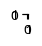

In [1]:
%load_ext autoreload
%autoreload 2
import os, sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

import pandas as pd
import numpy as np
import sklearn
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
f,a = plt.subplots(1,1,figsize=(1e-2, 1e-2))
mpl.rcParams['figure.dpi'] = 180
sns.set_style('darkgrid')
# pd.set_option("display.max_columns",999)
# pd.set_option("display.max_rows",100)

import warnings
warnings.filterwarnings("ignore")

from tqdm.auto import tqdm
from torch import optim
from datetime import datetime as dt
from src.utils import mkdirs, convert_path, pkl_dump, pkl_load, display_side
from src.data_processing import encode_batch_weighted, onehot_batch_decode, onehot_decode, INT_TO_CHAR, HLAS, AA_KEYS
from src.data_processing import get_tensor_dataset, encode_batch, BL62_VALUES, BL62FREQ_VALUES, get_array_dataset
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit
from src.metrics import get_metrics, plot_roc_auc_fold, get_mean_roc_curve, get_pred_df, get_mean_pr_curve
from src.metrics import get_nested_feature_importance, plot_feature_importance, get_roc
from src.train_eval import kcv_tune_sklearn, evaluate_trained_models_sklearn, nested_kcv_train_sklearn
from src.partition_tools import pipeline_stratified_kfold
from src.utils import pkl_load, pkl_dump

from scipy.stats import ttest_ind, mannwhitneyu, wilcoxon
from sklearn.ensemble import RandomForestClassifier

PAL = sns.color_palette('hsv', n_colors=13)
HSV = [PAL[-4], PAL[-1], PAL[0], PAL [4]]
mpl.rcParams['figure.dpi'] = 180

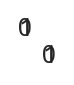

In [2]:
mpl.rcParams['figure.dpi'] = 180
sns.set_palette(HSV)
f,a = plt.subplots(1,1,figsize=(1e-7,1e-7))

# init

## reloading datasets

In [3]:
cedar_related = pd.read_csv('../data/mutant/221028_cedar_related_newcore_fold.csv')
prime_related = pd.read_csv('../data/mutant/221028_prime_related_newcore.csv')
ibel = pd.read_csv('../data/mutant/221111_ibel_neoepi_scored_merged.csv')
cp_merged = pd.read_csv('../data/mutant/221112_cedar_prime_merged_fold.csv')

In [4]:
# ICS DICT
ics_kl = pkl_load('../data/ic_dicts/ics_kl.pkl')
ics_shannon = pkl_load('../data/ic_dicts/ics_shannon.pkl')

MAPPING= {'RandomForestClassifier': 'RF',
          'LogisticRegression': 'LogReg',
          'XGBClassifier': 'XGB',
          'FFN': 'FFN'}

## Baselines

3480


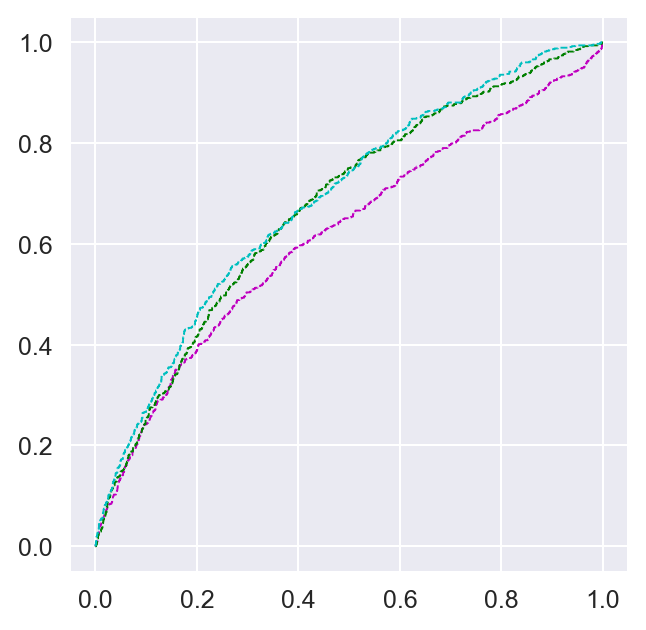

In [5]:
from src.baselines import plot_baseline_roc, plot_related_baseline_roc
cedar_baseline = pd.read_csv('../data/baselines/cedar_baseline.csv')
cedar_related_baseline = pd.read_csv('../data/baselines/cedar_related_baseline.csv')
prime = pd.read_csv('../data/baselines/prime_baseline.csv')
prime_related_baseline = pd.read_csv('../data/baselines/prime_related_baseline.csv')
f,a = plt.subplots(1,1, figsize=(4,4))
plot_baseline_roc(a, cedar_baseline)

In [6]:
from src.baselines import plot_related_baseline_roc

Text(0.5, 1.0, 'Baseline ROCs on IBEL')

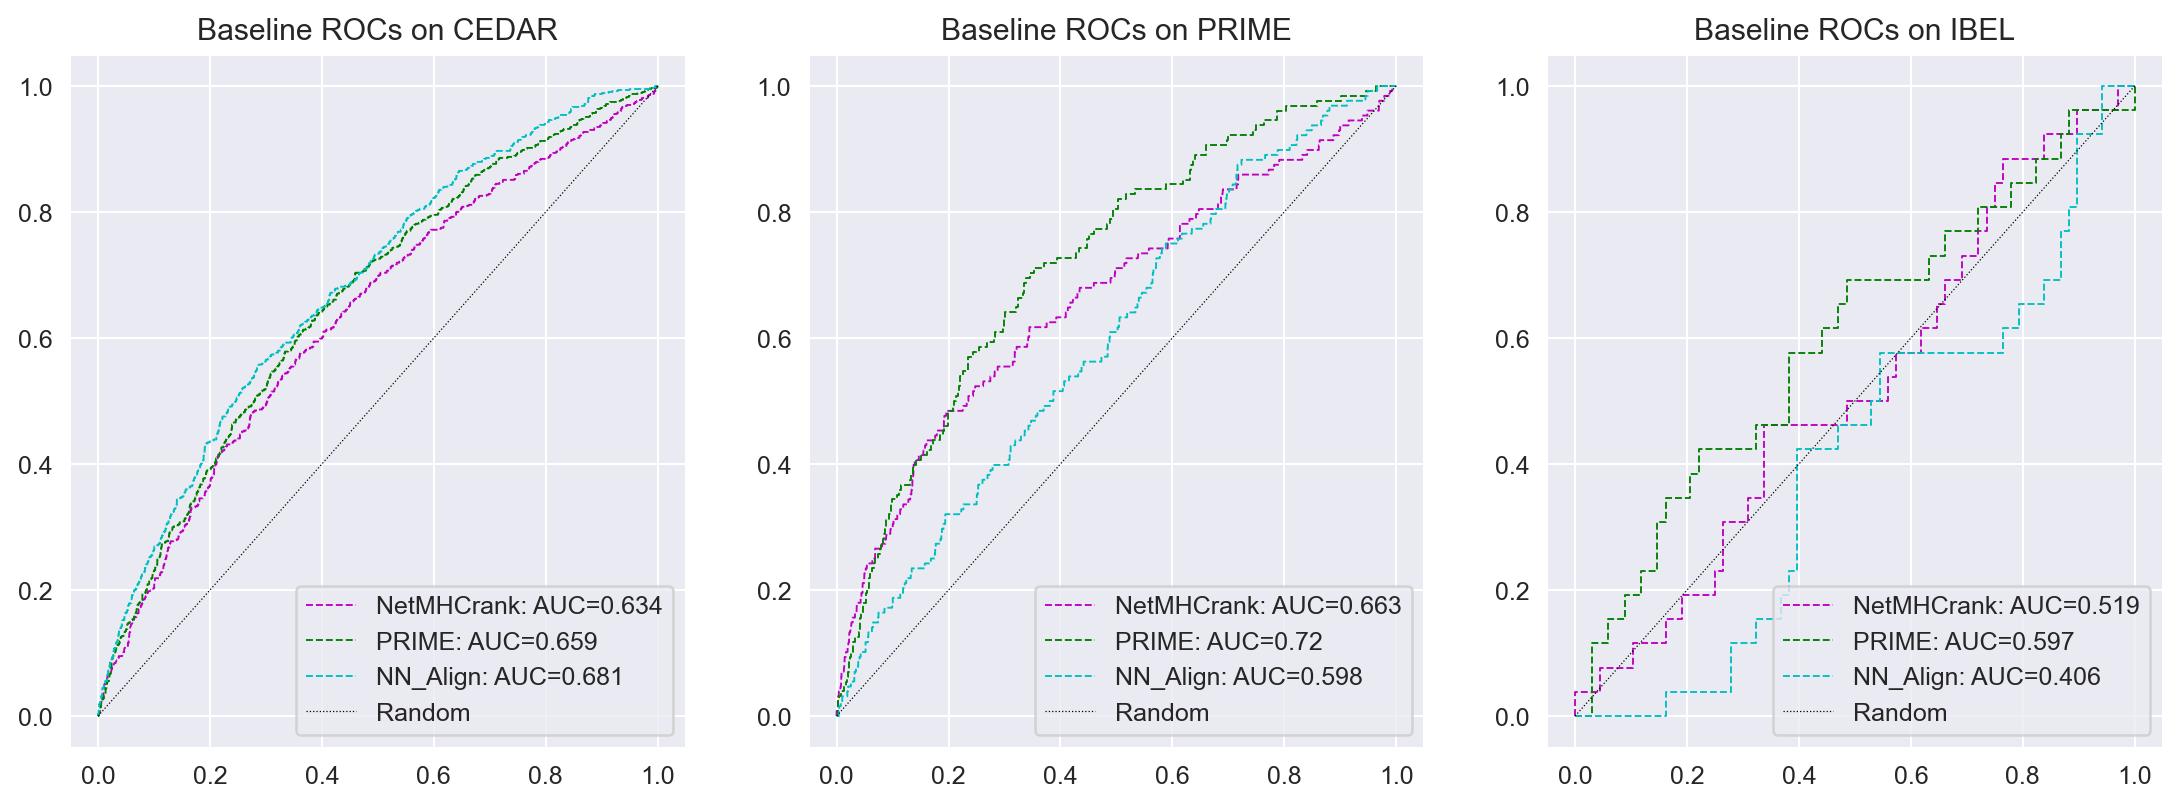

In [7]:
f,a = plt.subplots(1,3, figsize=(15,5))
plot_related_baseline_roc(axis=a[1], dataset=prime_related_baseline)
# a[1].plot([0,1],[0,1], label='Random', ls='--', lw=0.5, c='k')
a[1].legend(loc='lower right')
a[1].set_title('Baseline ROCs on PRIME')
plot_related_baseline_roc(axis=a[0], dataset=cedar_related_baseline)
# a[0].plot([0,1],[0,1], label='Random', ls='--', lw=0.5, c='k')
a[0].legend(loc='lower right')
a[0].set_title('Baseline ROCs on CEDAR')

plot_related_baseline_roc(axis=a[2], dataset=ibel)
# a[2].plot([0,1],[0,1], label='Random', ls='--', lw=0.5, c='k')
a[2].legend(loc='lower right')
a[2].set_title('Baseline ROCs on IBEL')

### Check various nnalign baselines

In [ ]:
cedar_nnalign = pd.read_csv('../../nnalign_cedar/output_baseline/221115_cedar_related.pep_27756/221115_cedar_related.pep_27756.lg6.sorted.pred', sep='\t').sort_values('Peptide')
prime_nnalign = pd.read_csv('../../nnalign_cedar/output_baseline/221115_prime_related.pep_35945/221115_prime_related.pep_35945.lg6.sorted.pred', sep='\t').sort_values('Peptide')
ibel_nnalign = pd.read_csv('../../nnalign_cedar/output_baseline/221115_ibel_related.pep_23423/221115_ibel_related.pep_23423.lg6.sorted.pred', sep='\t').sort_values('Peptide')
merged_nnalign = pd.read_csv('../../nnalign_cedar/output_baseline/221115_cedar_prime_merged.pep_11365/221115_cedar_prime_merged.pep_11365.lg6.sorted.pred', sep='\t').sort_values('Peptide')

In [91]:
cedar_nnalign_len8 = pd.read_csv('../../nnalign_cedar/output_baseline/221115_cedar_related_LEN8.pep/221115_cedar_related.pep_9059.lg8.sorted.pred', sep='\t').sort_values('Peptide')
prime_nnalign_len8 = pd.read_csv('../../nnalign_cedar/output_baseline/221115_prime_related_LEN8.pep_16861/221115_prime_related.pep_16861.lg8.sorted.pred', sep='\t').sort_values('Peptide')
ibel_nnalign_len8 = pd.read_csv('../../nnalign_cedar/output_baseline/221115_ibel_related_LEN8.pep_4773/221115_ibel_related.pep_4773.lg8.sorted.pred', sep='\t').sort_values('Peptide')
merged_nnalign_len8 = pd.read_csv('../../nnalign_cedar/output_baseline/221115_cedar_prime_merged_LEN8.pep_34147/221115_cedar_prime_merged.pep_34147.lg8.sorted.pred', sep='\t').sort_values('Peptide')

Text(0.5, 0.98, 'P1_Rel for different datasets; KDE and histograms')

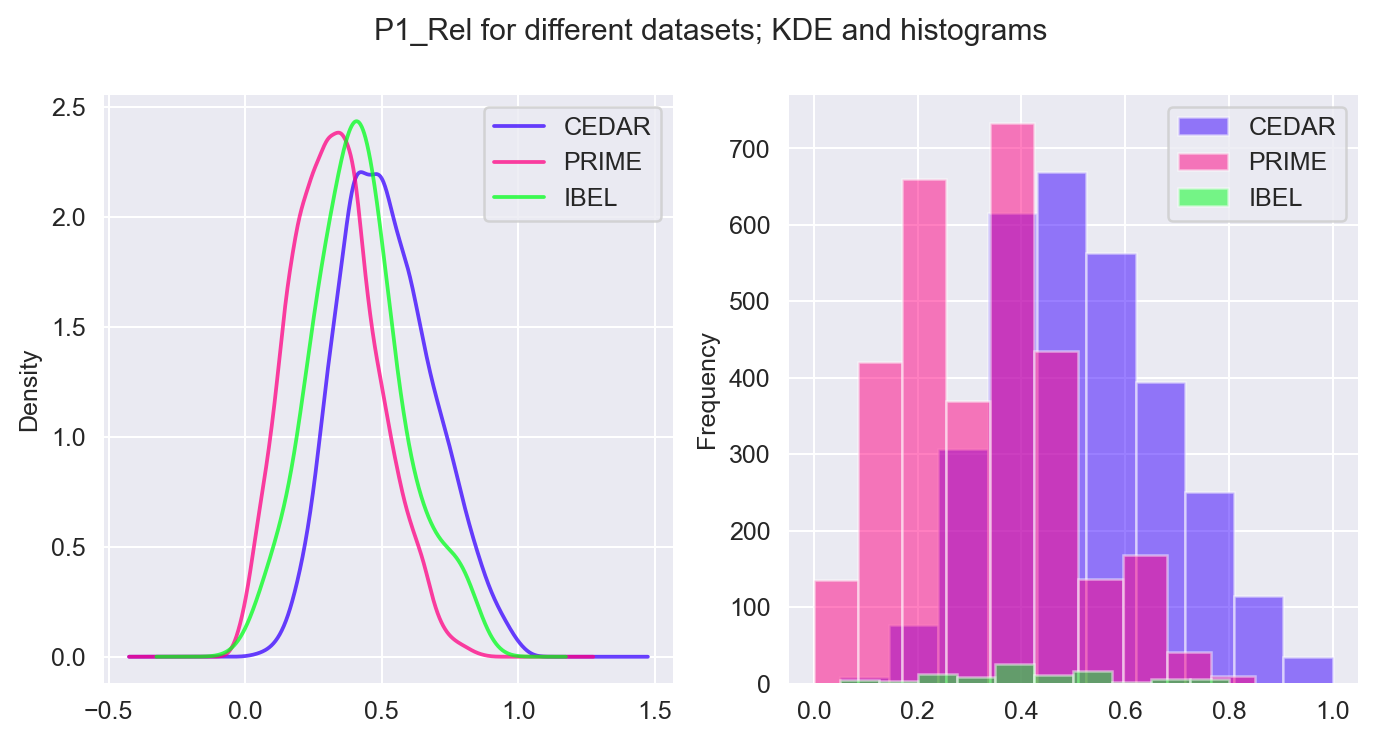

In [84]:
f,a = plt.subplots(1,2, figsize=(9, 4.25))
cedar_nnalign.plot(kind='kde', y='P1_Rel', ax=a[0], alpha=0.75, c=HSV[0], label='CEDAR')
prime_nnalign.plot(kind='kde', y='P1_Rel', ax=a[0], alpha=0.75, c=HSV[1], label='PRIME')
ibel_nnalign.plot(kind='kde', y='P1_Rel', ax=a[0], alpha=0.75, c=HSV[-1], label='IBEL')

cedar_nnalign.plot(kind='hist', y='P1_Rel', ax=a[1], alpha=0.5, color=HSV[0], label='CEDAR')
prime_nnalign.plot(kind='hist', y='P1_Rel', ax=a[1], alpha=0.5, color=HSV[1], label='PRIME')
ibel_nnalign.plot(kind='hist', y='P1_Rel', ax=a[1], alpha=0.5, color=HSV[-1], label='IBEL')
f.suptitle('P1_Rel for different datasets; KDE and histograms')

Text(0.5, 0.98, 'P1_Rel for different datasets; KDE and histograms')

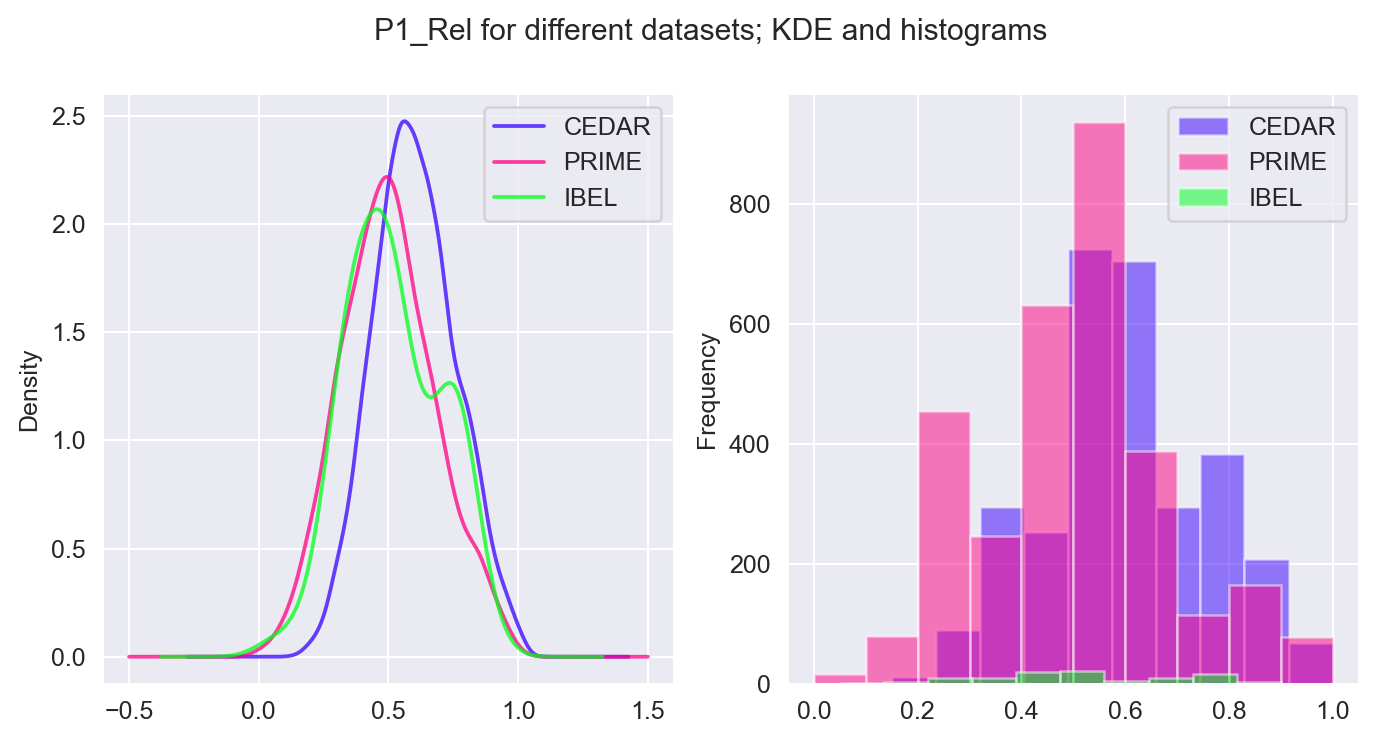

In [92]:
f,a = plt.subplots(1,2, figsize=(9, 4.25))
cedar_nnalign_len8.plot(kind='kde', y='P1_Rel', ax=a[0], alpha=0.75, c=HSV[0], label='CEDAR')
prime_nnalign_len8.plot(kind='kde', y='P1_Rel', ax=a[0], alpha=0.75, c=HSV[1], label='PRIME')
ibel_nnalign_len8.plot(kind='kde', y='P1_Rel', ax=a[0], alpha=0.75, c=HSV[-1], label='IBEL')

cedar_nnalign_len8.plot(kind='hist', y='P1_Rel', ax=a[1], alpha=0.5, color=HSV[0], label='CEDAR')
prime_nnalign_len8.plot(kind='hist', y='P1_Rel', ax=a[1], alpha=0.5, color=HSV[1], label='PRIME')
ibel_nnalign_len8.plot(kind='hist', y='P1_Rel', ax=a[1], alpha=0.5, color=HSV[-1], label='IBEL')
f.suptitle('P1_Rel for different datasets; KDE and histograms')

In [98]:
nnalign_results = {}
print('NNalign scores as baseline')
for name, df in zip(['CEDAR', 'PRIME', 'IBEL', 'MERGED'], [cedar_nnalign,prime_nnalign,ibel_nnalign,merged_nnalign]):
    df['target'] = df.Measure.astype(int)
    nnalign_results[name] = get_roc(df, score='Prediction', target='target')
    print(name, nnalign_results[name]['auc'], nnalign_results[name]['auc01'])

NNalign scores as baseline
CEDAR 0.6775372741415963 0.5539166522962452
PRIME 0.6144527318852734 0.5163612969861756
IBEL 0.40554298642533937 0.47368421052631576
MERGED 0.6702893279732787 0.548123061349165


In [99]:
nnalign_results_len8 = {}
print('NNalign scores as baseline')
for name, df in zip(['CEDAR', 'PRIME', 'IBEL', 'MERGED'], [cedar_nnalign_len8, prime_nnalign_len8, ibel_nnalign_len8, merged_nnalign_len8] ):
    df['target'] = df.Measure.astype(int)
    nnalign_results_len8[name] = get_roc(df, score='Prediction', target='target')
    print(name, nnalign_results[name]['auc'], nnalign_results[name]['auc01'])

NNalign scores as baseline
CEDAR 0.6775372741415963 0.5539166522962452
PRIME 0.6144527318852734 0.5163612969861756
IBEL 0.40554298642533937 0.47368421052631576
MERGED 0.6702893279732787 0.548123061349165


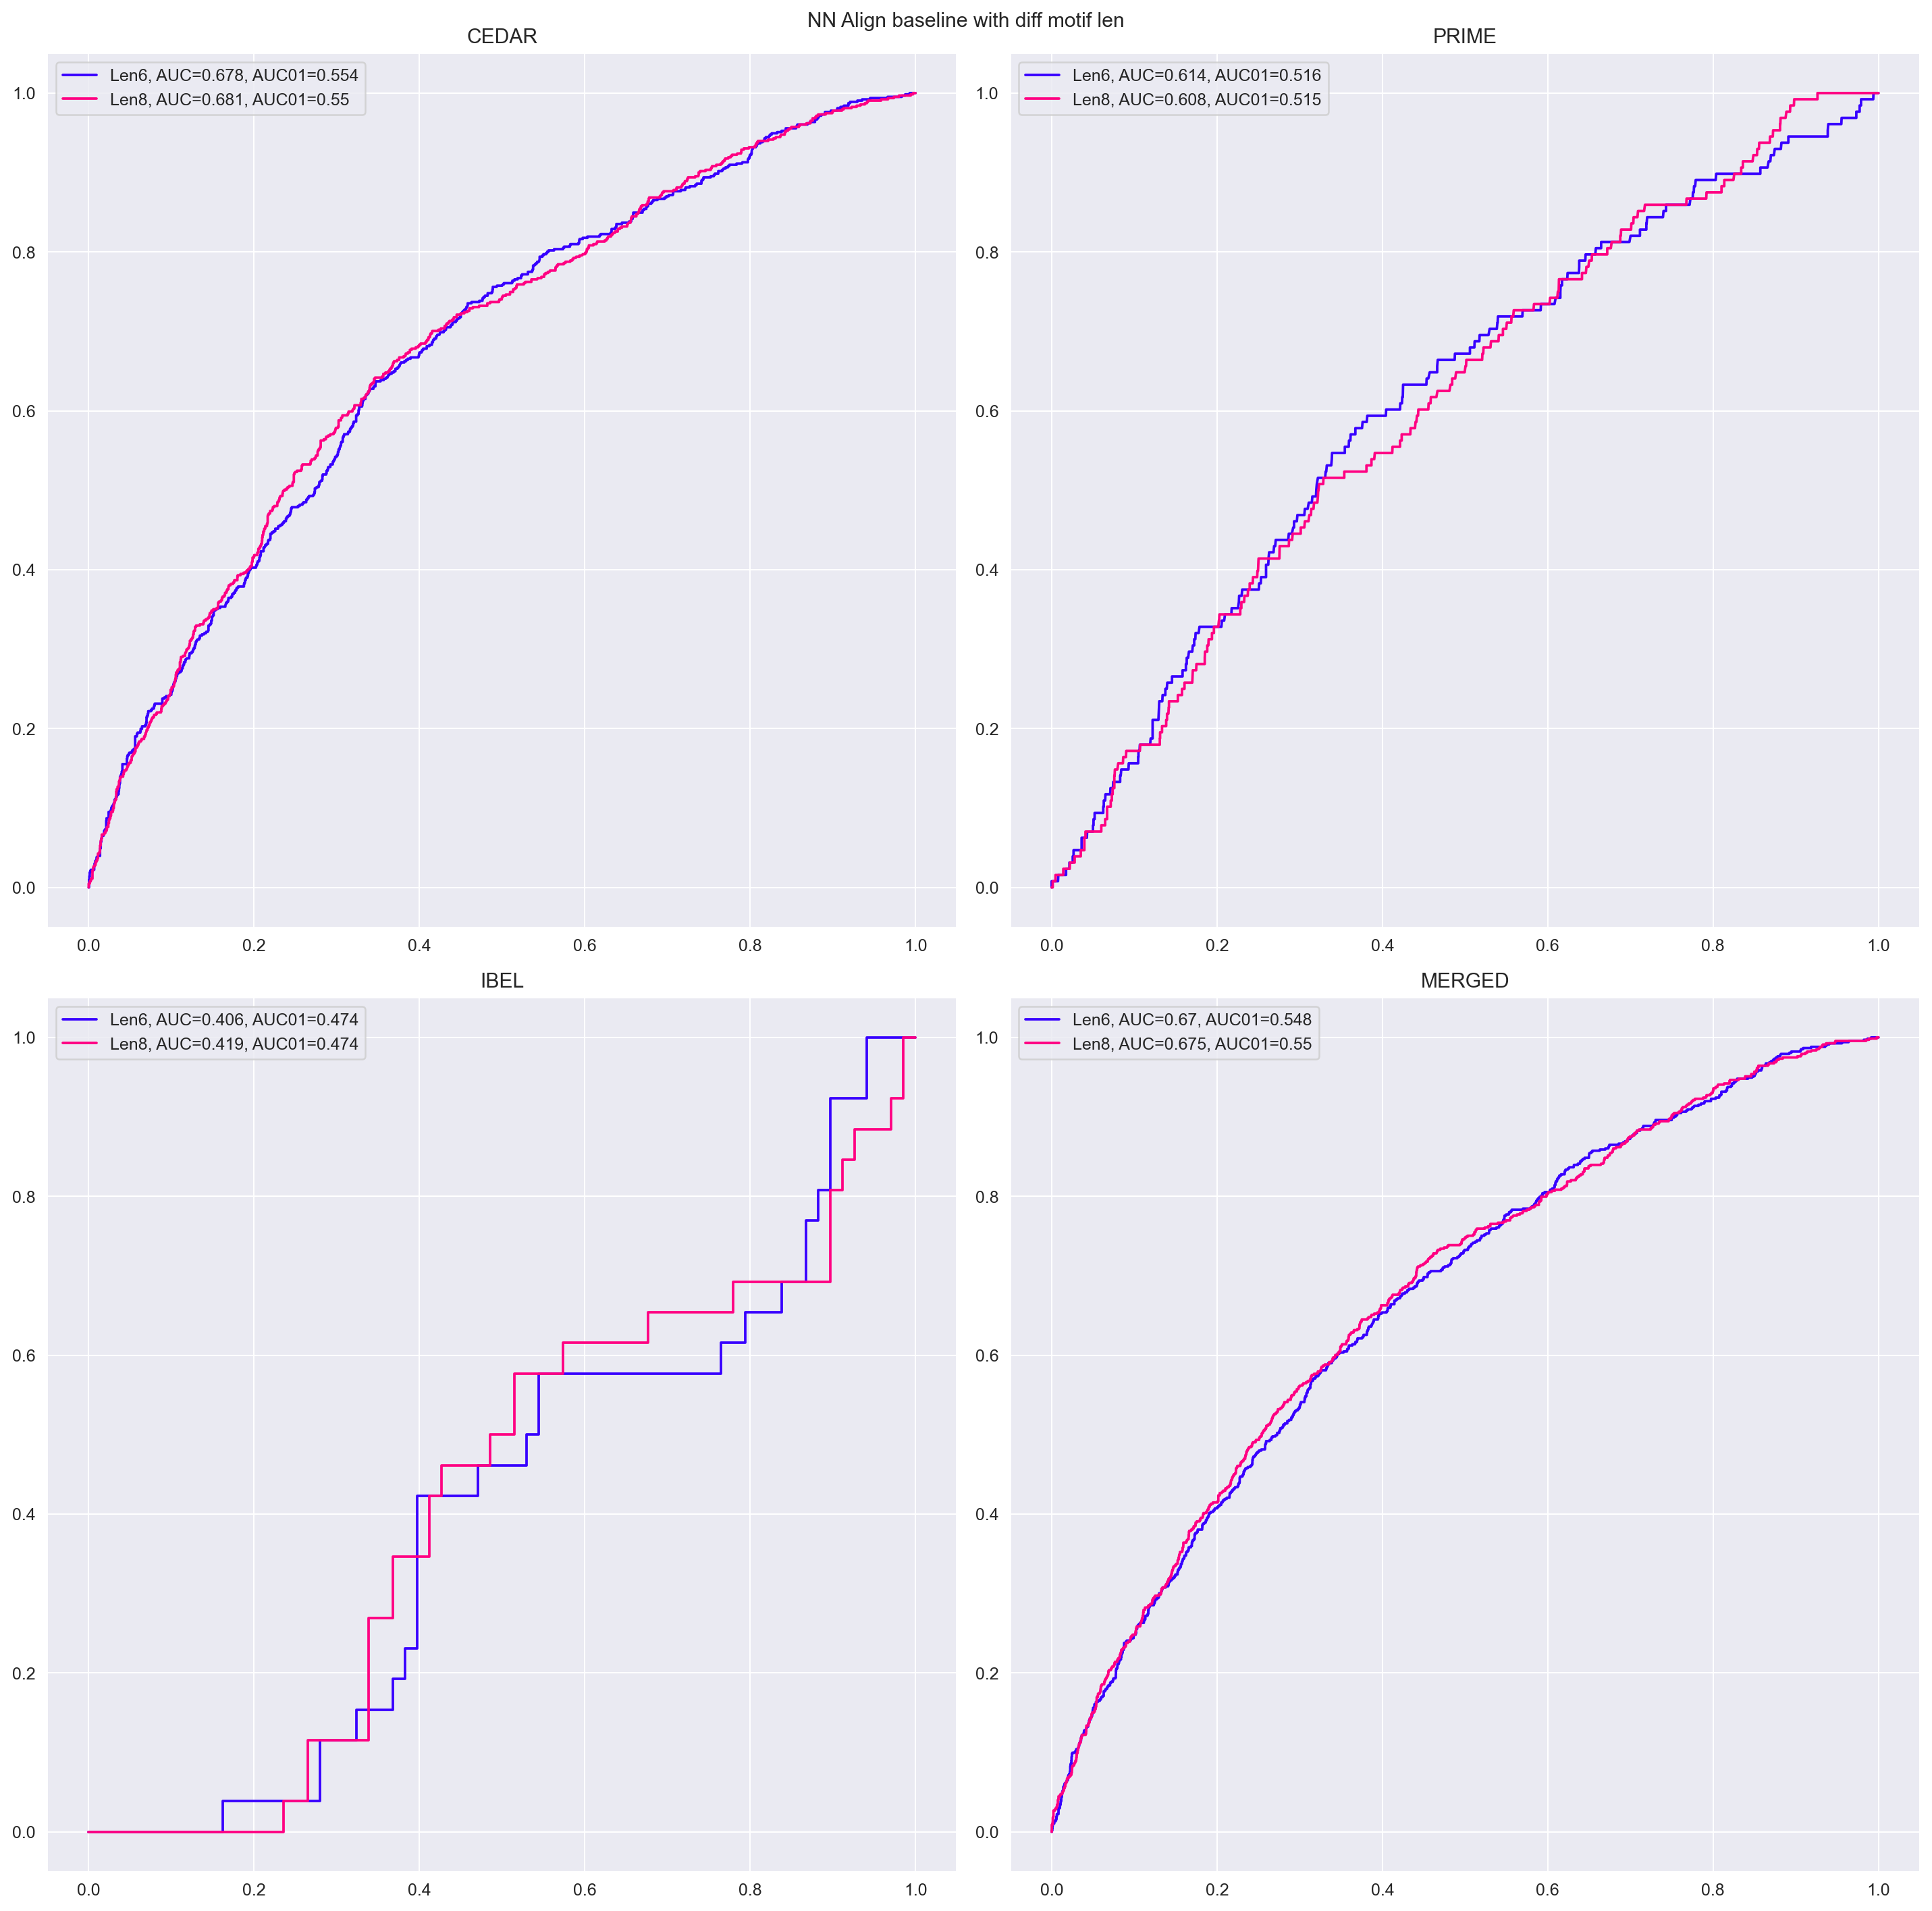

In [103]:
f,a = plt.subplots(2,2,figsize=(16,16))
ax = a.ravel()
for i, k in enumerate(nnalign_results.keys()):
    sns.lineplot(x=nnalign_results[k]['roc'][0], y=nnalign_results[k]['roc'][1], ax=ax[i], estimator=None,
                 label = f"Len6, AUC={round(nnalign_results[k]['auc'],3)}, AUC01={round(nnalign_results[k]['auc01'],3)}")
    sns.lineplot(x=nnalign_results_len8[k]['roc'][0], y=nnalign_results_len8[k]['roc'][1], ax=ax[i], estimator=None,
                 label = f"Len8, AUC={round(nnalign_results_len8[k]['auc'],3)}, AUC01={round(nnalign_results_len8[k]['auc01'],3)}")
    ax[i].set_title(k)
f.suptitle('NN Align baseline with diff motif len')
f.tight_layout()

# Results

In [9]:
df_results_merged = pd.read_csv('../output/221112_new_core_mutscores_mergedtrainset/bootstrapping/total_df.csv')
df_results = pd.read_csv('../output/221112_new_core_mutscores_mergedtrainset/total_df_without_merged_results.csv')
df_results = pd.concat([df_results, df_results_merged])
del df_results_merged
df_results.to_csv('../output/221112_new_core_mutscores_mergedtrainset/total_df_all.csv',index=False)

KeyboardInterrupt: 

In [10]:
df_results = pd.read_csv('../output/221112_new_core_mutscores_mergedtrainset/total_df_all.csv')

In [11]:
def weight_name(weight):
    if weight=='None':
        return weight
    elif 'Inverted' in weight:
        weight = weight.replace('Inverted ', '')
        return f'IC {weight}'
    else:
        return f'(1–IC) {weight}'
df_results['weight'] = df_results['weight'].apply(weight_name)
df_results.weight.unique()

array(['IC Mask', 'IC KL', 'IC Shannon', '(1–IC) Mask', '(1–IC) KL',
       'None', '(1–IC) Shannon'], dtype=object)

## reshape results

In [12]:
score_cols = ['auc', 'prauc', 'AP', 'auc_01', 'f1', 'accuracy', 'precision', 'recall']
feat_cols = ['encoding', 'weight','pep_col', 'rank_col', 'key']

df_prime = df_results.query('evalset=="PRIME"').drop(columns=['evalset']).reset_index(drop=True)
df_prime.rename(columns = {k:f'{k}_prime' for k in score_cols}, inplace=True)

df_cedar = df_results.query('evalset=="CEDAR"').drop(columns=['evalset']).reset_index(drop=True)
df_cedar.rename(columns = {k:f'{k}_cedar' for k in score_cols}, inplace=True)

df_ibel = df_results.query('evalset=="IBEL"').drop(columns=['evalset']).reset_index(drop=True)
df_ibel.rename(columns = {k:f'{k}_ibel' for k in score_cols}, inplace=True)

df_merged = df_results.query('evalset=="MERGED"').drop(columns=['evalset']).reset_index(drop=True)
df_merged.rename(columns = {k:f'{k}_merged' for k in score_cols}, inplace=True)

df_reshape = df_cedar.merge(df_prime.drop(columns = feat_cols), left_index=True, right_index=True)\
                     .merge(df_ibel.drop(columns = feat_cols), left_index=True, right_index=True)\
                     .merge(df_merged.drop(columns= feat_cols), left_index=True, right_index=True)

del df_prime
del df_cedar
del df_ibel
del df_merged

## gb_agg checks

In [14]:
# Only keep models that use EL rank mut as rank 
gb_agg = df_results.query('rank_col=="EL_rank_mut"').groupby(['encoding', 'weight', 'pep_col', 'rank_col', 'key', 'evalset']).agg(max_AUC=('auc', 'max'),
                                                                                                 mean_AUC=('auc', 'mean'),
                                                                                                 med_AUC=('auc', 'median'),
                                                                                                 std_AUC=('auc', 'std'), 
                                                                                                 max_PRAUC=('prauc', 'max'),
                                                                                                 mean_PRAUC=('prauc', 'mean'),
                                                                                                 med_PRAUC=('prauc', 'median'),
                                                                                                 std_PRAUC=('prauc', 'std')).reset_index('evalset')

gb_reshape = df_reshape.groupby(['encoding', 'weight', 'pep_col', 'rank_col', 'key']).agg(max_AUC_cedar=('auc_cedar', 'max'),
                                                                                          mean_AUC_cedar=('auc_cedar', 'mean'),
                                                                                          max_PRAUC_cedar=('prauc_cedar', 'max'),
                                                                                          mean_PRAUC_cedar=('prauc_cedar', 'mean'),
                                                                                          max_AUC_prime=('auc_prime', 'max'),
                                                                                          mean_AUC_prime=('auc_prime', 'mean'),
                                                                                          max_PRAUC_prime=('prauc_prime', 'max'),
                                                                                          mean_PRAUC_prime=('prauc_prime', 'mean'),
                                                                                          max_AUC_ibel=('auc_ibel', 'max'),
                                                                                          mean_AUC_ibel=('auc_ibel', 'mean'),
                                                                                          max_PRAUC_ibel=('prauc_ibel', 'max'),
                                                                                          mean_PRAUC_ibel=('prauc_ibel', 'mean'),
                                                                                          max_AUC_merged=('auc_merged', 'max'),
                                                                                          mean_AUC_merged=('auc_merged', 'mean'),
                                                                                          max_PRAUC_merged=('prauc_merged', 'max'),
                                                                                          mean_PRAUC_merged=('prauc_merged', 'mean'))

## top means etc

In [15]:
top25_mean_cedar = gb_reshape.sort_values('mean_AUC_cedar', ascending=False).head(25)
top25_mean_prime = gb_reshape.sort_values('mean_AUC_prime', ascending=False).head(25)
top25_mean_ibel = gb_reshape.sort_values('mean_AUC_ibel', ascending=False).head(25)
top25_mean_merged = gb_reshape.sort_values('mean_AUC_merged', ascending=False).head(25)


In [21]:
auc_cols = list(filter(lambda x: 'PR' not in x and 'AUC' in x and 'mean' in x, top25_mean_cedar.columns))
auc_cols

['mean_AUC_cedar', 'mean_AUC_prime', 'mean_AUC_ibel', 'mean_AUC_merged']

In [22]:
# MERGED
from IPython.core.display import display, HTML
output = top25_mean_merged[auc_cols].head(15).to_html(formatters={col: '{:,.3%}'.format for col in auc_cols})
display(HTML(output))

In [23]:
tmp = top25_mean_merged.reset_index('key').groupby('key').agg(x=('max_AUC_merged','count'))
merged_appearances={}
idx=list(tmp.index)
vals=tmp.x.values
for k,v in zip(idx,vals):
    names = k.split('-')
    for n in names:
        if n in merged_appearances.keys():
            merged_appearances[n]+=v
        else:
            merged_appearances[n]=v
merged_appearances

{'blsm_mut_score': 13,
 'mutation_score': 25,
 'ratio_rank': 11,
 'dissimilarity_score': 12}

In [24]:
from IPython.core.display import display, HTML
output = top25_mean_cedar[auc_cols].head(15).to_html(formatters={col: '{:,.3%}'.format for col in auc_cols})
display(HTML(output))

In [25]:
tmp = top25_mean_cedar.reset_index('key').groupby('key').agg(x=('max_AUC_cedar','count'))
cedar_appearances={}
idx=list(tmp.index)
vals=tmp.x.values
for k,v in zip(idx,vals):
    names = k.split('-')
    for n in names:
        if n in cedar_appearances.keys():
            cedar_appearances[n]+=v
        else:
            cedar_appearances[n]=v
cedar_appearances

{'aa_props': 10,
 'blsm_mut_score': 8,
 'mutation_score': 8,
 'ratio_rank': 3,
 'core_blsm_mut_score': 2,
 'dissimilarity_score': 3,
 'only_rank': 1}

### PRIME

In [26]:
from IPython.core.display import display, HTML
output = top25_mean_prime[auc_cols].head(15).to_html(formatters={col: '{:,.3%}'.format for col in auc_cols})
display(HTML(output))

In [110]:
tmp = top25_mean_prime.reset_index('key').groupby('key').agg(x=('max_AUC_prime','count'))
prime_appearances={}
idx=list(tmp.index)
vals=tmp.x.values
for k,v in zip(idx,vals):
    names = k.split('-')
    for n in names:
        if n in prime_appearances.keys():
            prime_appearances[n]+=v
        else:
            prime_appearances[n]=v
prime_appearances

{'blsm_mut_score': 5,
 'core_blsm_mut_score': 10,
 'core_mutation_score': 14,
 'dissimilarity_score': 15,
 'ratio_rank': 1,
 'only_rank': 1}

### IBEL

In [28]:
from IPython.core.display import display, HTML
output = top25_mean_ibel[auc_cols].head(15).to_html(formatters={col: '{:,.3%}'.format for col in auc_cols})
display(HTML(output))

In [191]:
tmp = top25_mean_ibel.reset_index('key').groupby('key').agg(x=('mean_AUC_ibel','count'))
ibel_appearances={}
idx=list(tmp.index)
vals=tmp.x.values
for k,v in zip(idx,vals):
    names = k.split('-')
    for n in names:
        if n in ibel_appearances.keys():
            ibel_appearances[n]+=v
        else:
            ibel_appearances[n]=v
ibel_appearances

{'blsm_mut_score': 20,
 'mutation_score': 19,
 'dissimilarity_score': 20,
 'ratio_rank': 8}

In [39]:
print('cedar', cedar_appearances, )
print('prime', prime_appearances, )
print('ibel_', ibel_appearances)


cedar {'aa_props': 7, 'blsm_mut_score': 10, 'mutation_score': 10, 'ratio_rank': 4, 'core_blsm_mut_score': 2, 'dissimilarity_score': 4, 'only_rank': 2}
prime {'blsm_mut_score': 4, 'core_blsm_mut_score': 11, 'core_mutation_score': 14, 'dissimilarity_score': 16, 'ratio_rank': 1, 'only_rank': 1}
ibel_ {'blsm_mut_score': 15, 'mutation_score': 24, 'ratio_rank': 10, 'dissimilarity_score': 11}


## quick pvalue stuff

In [293]:
gb_agg.sort_values('mean_AUC', ascending=False).head(20).reset_index()\
                                        .query('evalset=="CEDAR"')[['encoding', 'weight', 'pep_col', 'rank_col' ,'key']].values

array([['onehot', 'Inverted KL', 'Peptide', 'EL_rank_mut', 'aa_props'],
       ['onehot', 'Inverted Shannon', 'icore_mut', 'EL_rank_mut',
        'aa_props'],
       ['onehot', 'Inverted Shannon', 'Peptide', 'EL_rank_mut',
        'aa_props'],
       ['onehot', 'Inverted KL', 'icore_mut', 'EL_rank_mut', 'aa_props'],
       ['onehot', 'Inverted KL', 'Peptide', 'trueHLA_EL_rank',
        'aa_props'],
       ['onehot', 'Inverted KL', 'Peptide', 'EL_rank_mut',
        'mutation_score-ratio_rank'],
       ['BL62FREQ', 'Inverted Shannon', 'icore_mut', 'EL_rank_mut',
        'aa_props'],
       ['onehot', 'Inverted Shannon', 'Peptide', 'trueHLA_EL_rank',
        'aa_props'],
       ['onehot', 'Inverted KL', 'Peptide', 'EL_rank_mut',
        'blsm_mut_score-mutation_score'],
       ['onehot', 'Inverted KL', 'Peptide', 'EL_rank_mut',
        'core_blsm_mut_score-ratio_rank'],
       ['onehot', 'Inverted KL', 'Peptide', 'EL_rank_mut',
        'blsm_mut_score-ratio_rank'],
       ['onehot', 'Inve

In [180]:
auc_a = df_a.auc.values
auc_b = df_results.query('encoding=="BL62FREQ" and evalset=="CEDAR" and rank_col=="EL_rank_mut" and key=="aa_props" and pep_col=="icore_mut" and weight=="Shannon"').auc.values
a_over_b = [x>y for x,y in zip(auc_a, auc_b)]
pval = 1 - (len((auc_a>auc_b).astype(int).nonzero()[0]) / 10000 )
pval

0.0010999999999999899

In [248]:
df_results.columns

Index(['auc', 'prauc', 'AP', 'auc_01', 'f1', 'accuracy', 'precision', 'recall',
       'encoding', 'weight', 'pep_col', 'rank_col', 'key', 'evalset'],
      dtype='object')

# plots

## ROCs

In [31]:
print('top25_mean_cedar')
display(top25_mean_cedar.head(1)[auc_cols])
print('top25_mean_prime')
display(top25_mean_prime.head(1)[auc_cols])
print('top25_mean_ibel')
display(top25_mean_ibel.head(1)[auc_cols])
print('top25_mean_merged')
display(top25_mean_merged.head(1)[auc_cols])

gb_reshape['mean_CEDAR_PRIME_AUC'] = gb_reshape.apply(lambda x: np.mean([x['mean_AUC_cedar'], x['mean_AUC_prime'], x['mean_AUC_ibel']]), axis=1)
gb_reshape['mean_CEDAR_PRIME_AUC_weighted'] = 0.75*gb_reshape['mean_AUC_cedar']+0.25*gb_reshape['mean_AUC_prime']+0.25*gb_reshape['mean_AUC_ibel']
print('mean')
display(gb_reshape.sort_values('mean_CEDAR_PRIME_AUC',ascending=False).head(1)[auc_cols])
print('weighted')
display(gb_reshape.sort_values('mean_CEDAR_PRIME_AUC_weighted',ascending=False).head(1)[auc_cols])

top25_mean_cedar


mean_AUC_cedar  mean_AUC_prime  \
encoding weight pep_col rank_col    key                                        
onehot   IC KL  Peptide EL_rank_mut aa_props        0.728261        0.687683   

                                              mean_AUC_ibel  mean_AUC_merged  
encoding weight pep_col rank_col    key                                       
onehot   IC KL  Peptide EL_rank_mut aa_props       0.573483         0.723463

top25_mean_prime


mean_AUC_cedar  \
encoding weight      pep_col rank_col    key                                                       
onehot   (1–IC) Mask Peptide EL_rank_mut dissimilarity_score-core_mutation_score        0.700505   

                                                                                  mean_AUC_prime  \
encoding weight      pep_col rank_col    key                                                       
onehot   (1–IC) Mask Peptide EL_rank_mut dissimilarity_score-core_mutation_score        0.727533   

                                                                                  mean_AUC_ibel  \
encoding weight      pep_col rank_col    key                                                      
onehot   (1–IC) Mask Peptide EL_rank_mut dissimilarity_score-core_mutation_score       0.549523   

                                                                                  mean_AUC_merged  
encoding weight      pep_col rank_col    key                                                       
onehot   (1–IC) Mask Peptide EL_rank_mut dissimilarity_score-core_mutation_score         0.712286

top25_mean_ibel


mean_AUC_cedar  \
encoding weight         pep_col rank_col        key                                                                 
onehot   (1–IC) Shannon Peptide trueHLA_EL_rank dissimilarity_score-blsm_mut_score-mutation_score        0.696682   

                                                                                                   mean_AUC_prime  \
encoding weight         pep_col rank_col        key                                                                 
onehot   (1–IC) Shannon Peptide trueHLA_EL_rank dissimilarity_score-blsm_mut_score-mutation_score        0.660428   

                                                                                                   mean_AUC_ibel  \
encoding weight         pep_col rank_col        key                                                                
onehot   (1–IC) Shannon Peptide trueHLA_EL_rank dissimilarity_score-blsm_mut_score-mutation_score       0.678363   

                                                                                                   mean_AUC_merged  
encoding weight         pep_col rank_col        key                                                                 
onehot   (1–IC) Shannon Peptide trueHLA_EL_rank dissimilarity_score-blsm_mut_score-mutation_score         0.813261

top25_mean_merged


mean_AUC_cedar  \
encoding weight         pep_col   rank_col    key                                                                 
onehot   (1–IC) Shannon icore_mut EL_rank_mut dissimilarity_score-blsm_mut_score-mutation_score        0.714302   

                                                                                                 mean_AUC_prime  \
encoding weight         pep_col   rank_col    key                                                                 
onehot   (1–IC) Shannon icore_mut EL_rank_mut dissimilarity_score-blsm_mut_score-mutation_score        0.670563   

                                                                                                 mean_AUC_ibel  \
encoding weight         pep_col   rank_col    key                                                                
onehot   (1–IC) Shannon icore_mut EL_rank_mut dissimilarity_score-blsm_mut_score-mutation_score       0.643095   

                                                                                                 mean_AUC_merged  
encoding weight         pep_col   rank_col    key                                                                 
onehot   (1–IC) Shannon icore_mut EL_rank_mut dissimilarity_score-blsm_mut_score-mutation_score         0.826389

mean


mean_AUC_cedar  \
encoding weight         pep_col rank_col    key                                             
onehot   (1–IC) Shannon Peptide EL_rank_mut blsm_mut_score-mutation_score        0.707047   

                                                                           mean_AUC_prime  \
encoding weight         pep_col rank_col    key                                             
onehot   (1–IC) Shannon Peptide EL_rank_mut blsm_mut_score-mutation_score        0.684864   

                                                                           mean_AUC_ibel  \
encoding weight         pep_col rank_col    key                                            
onehot   (1–IC) Shannon Peptide EL_rank_mut blsm_mut_score-mutation_score       0.662822   

                                                                           mean_AUC_merged  
encoding weight         pep_col rank_col    key                                             
onehot   (1–IC) Shannon Peptide EL_rank_mut blsm_mut_score-mutation_score         0.819113

weighted


mean_AUC_cedar  \
encoding weight         pep_col   rank_col    key                                             
onehot   (1–IC) Shannon icore_mut EL_rank_mut blsm_mut_score-mutation_score        0.713107   

                                                                             mean_AUC_prime  \
encoding weight         pep_col   rank_col    key                                             
onehot   (1–IC) Shannon icore_mut EL_rank_mut blsm_mut_score-mutation_score        0.680473   

                                                                             mean_AUC_ibel  \
encoding weight         pep_col   rank_col    key                                            
onehot   (1–IC) Shannon icore_mut EL_rank_mut blsm_mut_score-mutation_score       0.652141   

                                                                             mean_AUC_merged  
encoding weight         pep_col   rank_col    key                                             
onehot   (1–IC) Shannon icore_mut EL_rank_mut blsm_mut_score-mutation_score          0.82628

In [33]:
best_cedar_cdt = 'onehot_Inverted-KL_Peptide_EL_rank_mut_aa_props'
best_prime_cdt = 'onehot_Mask_Peptide_EL_rank_mut_dissimilarity_score-core_mutation_score'
best_ibel_cdt = 'onehot_Shannon_Peptide_EL_rank_mut_dissimilarity_score-blsm_mut_score-mutation_score'
best_merged_cdt = 'onehot_Shannon_icore_mut_EL_rank_mut_dissimilarity_score-blsm_mut_score-mutation_score'
best_mean_cdt = 'onehot_Shannon_Peptide_EL_rank_mut_blsm_mut_score-mutation_score'
best_weighted_cdt = 'onehot_Shannon_icore_mut_EL_rank_mut_blsm_mut_score-mutation_score'


In [34]:
dir_ = '../output/221112_new_core_mutscores_mergedtrainset/bootstrapping/'
# Best cedar cdt
best_cedar_cdt_cedar_roc = pkl_load(f'{dir_}cedar_mean_rocs_{best_cedar_cdt}.pkl')
best_cedar_cdt_prime_roc = pkl_load(f'{dir_}prime_mean_rocs_{best_cedar_cdt}.pkl')
best_cedar_cdt_ibel_roc = pkl_load(f'{dir_}ibel_mean_rocs_{best_cedar_cdt}.pkl')
best_cedar_cdt_merged_roc = pkl_load(f'{dir_}merged_mean_rocs_{best_cedar_cdt}.pkl')

# best prime cdt
best_prime_cdt_cedar_roc = pkl_load(f'{dir_}cedar_mean_rocs_{best_prime_cdt}.pkl')
best_prime_cdt_prime_roc = pkl_load(f'{dir_}prime_mean_rocs_{best_prime_cdt}.pkl')
best_prime_cdt_ibel_roc = pkl_load(f'{dir_}ibel_mean_rocs_{best_prime_cdt}.pkl')
best_prime_cdt_merged_roc = pkl_load(f'{dir_}merged_mean_rocs_{best_prime_cdt}.pkl')

# Best IBEL cdt
best_ibel_cdt_cedar_roc = pkl_load(f'{dir_}cedar_mean_rocs_{best_ibel_cdt}.pkl')
best_ibel_cdt_prime_roc = pkl_load(f'{dir_}prime_mean_rocs_{best_ibel_cdt}.pkl')
best_ibel_cdt_ibel_roc = pkl_load(f'{dir_}ibel_mean_rocs_{best_ibel_cdt}.pkl')
best_ibel_cdt_merged_roc = pkl_load(f'{dir_}merged_mean_rocs_{best_ibel_cdt}.pkl')

# Best MERGED cdt
best_merged_cdt_cedar_roc = pkl_load(f'{dir_}cedar_mean_rocs_{best_merged_cdt}.pkl')
best_merged_cdt_prime_roc = pkl_load(f'{dir_}prime_mean_rocs_{best_merged_cdt}.pkl')
best_merged_cdt_ibel_roc = pkl_load(f'{dir_}ibel_mean_rocs_{best_merged_cdt}.pkl')
best_merged_cdt_merged_roc = pkl_load(f'{dir_}merged_mean_rocs_{best_merged_cdt}.pkl')

# best mean cdt
best_mean_cdt_cedar_roc =  pkl_load(f'{dir_}cedar_mean_rocs_{best_mean_cdt}.pkl')
best_mean_cdt_prime_roc =  pkl_load(f'{dir_}prime_mean_rocs_{best_mean_cdt}.pkl')
best_mean_cdt_ibel_roc =  pkl_load(f'{dir_}ibel_mean_rocs_{best_mean_cdt}.pkl')
best_mean_cdt_ibel_roc =  pkl_load(f'{dir_}ibel_mean_rocs_{best_mean_cdt}.pkl')
# best weighted mean cdt
best_weighted_cdt_cedar_roc = pkl_load(f'{dir_}cedar_mean_rocs_{best_weighted_cdt}.pkl')
best_weighted_cdt_prime_roc = pkl_load(f'{dir_}prime_mean_rocs_{best_weighted_cdt}.pkl')
best_weighted_cdt_ibel_roc = pkl_load(f'{dir_}ibel_mean_rocs_{best_weighted_cdt}.pkl')
best_weighted_cdt_merged_roc = pkl_load(f'{dir_}merged_mean_rocs_{best_weighted_cdt}.pkl')

In [36]:
dir_raw = '../output/221112_new_core_mutscores_mergedtrainset/raw/'

# Best cedar cdt
best_cedar_cdt_cedar_preds = pd.read_csv(f'{dir_raw}cedar_preds_{best_cedar_cdt}.csv') 
best_cedar_cdt_prime_preds = pd.read_csv(f'{dir_raw}prime_preds_{best_cedar_cdt}.csv') 
best_cedar_cdt_ibel_preds = pd.read_csv(f'{dir_raw}ibel_preds_{best_cedar_cdt}.csv') 
best_cedar_cdt_merged_preds = pd.read_csv(f'{dir_raw}merged_preds_{best_cedar_cdt}.csv') 

# best prime cdt
best_prime_cdt_cedar_preds = pd.read_csv(f'{dir_raw}cedar_preds_{best_prime_cdt}.csv') 
best_prime_cdt_prime_preds = pd.read_csv(f'{dir_raw}prime_preds_{best_prime_cdt}.csv') 
best_prime_cdt_ibel_preds = pd.read_csv(f'{dir_raw}ibel_preds_{best_prime_cdt}.csv') 
best_prime_cdt_merged_preds = pd.read_csv(f'{dir_raw}merged_preds_{best_prime_cdt}.csv') 

# Best IBEL cdt
best_ibel_cdt_cedar_preds = pd.read_csv(f'{dir_raw}cedar_preds_{best_ibel_cdt}.csv') 
best_ibel_cdt_prime_preds = pd.read_csv(f'{dir_raw}prime_preds_{best_ibel_cdt}.csv') 
best_ibel_cdt_ibel_preds = pd.read_csv(f'{dir_raw}ibel_preds_{best_ibel_cdt}.csv') 
best_ibel_cdt_merged_preds = pd.read_csv(f'{dir_raw}merged_preds_{best_ibel_cdt}.csv') 

# Best MERGED cdt
best_merged_cdt_cedar_preds = pd.read_csv(f'{dir_raw}cedar_preds_{best_merged_cdt}.csv') 
best_merged_cdt_prime_preds = pd.read_csv(f'{dir_raw}prime_preds_{best_merged_cdt}.csv') 
best_merged_cdt_ibel_preds = pd.read_csv(f'{dir_raw}ibel_preds_{best_merged_cdt}.csv') 
best_merged_cdt_merged_preds = pd.read_csv(f'{dir_raw}merged_preds_{best_merged_cdt}.csv') 

# best mean cdt
best_mean_cdt_cedar_preds =  pd.read_csv(f'{dir_raw}cedar_preds_{best_mean_cdt}.csv') 
best_mean_cdt_prime_preds =  pd.read_csv(f'{dir_raw}prime_preds_{best_mean_cdt}.csv') 
best_mean_cdt_ibel_preds =  pd.read_csv(f'{dir_raw}ibel_preds_{best_mean_cdt}.csv') 
best_mean_cdt_ibel_preds =  pd.read_csv(f'{dir_raw}ibel_preds_{best_mean_cdt}.csv') 
# best weighted mean cdt
best_weighted_cdt_cedar_preds = pd.read_csv(f'{dir_raw}cedar_preds_{best_weighted_cdt}.csv') 
best_weighted_cdt_prime_preds = pd.read_csv(f'{dir_raw}prime_preds_{best_weighted_cdt}.csv') 
best_weighted_cdt_ibel_preds = pd.read_csv(f'{dir_raw}ibel_preds_{best_weighted_cdt}.csv') 
best_weighted_cdt_merged_preds = pd.read_csv(f'{dir_raw}merged_preds_{best_weighted_cdt}.csv') 

FileNotFoundError: [Errno 2] No such file or directory: '../output/221112_new_core_mutscores_mergedtrainset/raw/merged_preds_onehot_Inverted-KL_Peptide_EL_rank_mut_aa_props.csv'

In [214]:
df_ced.binder

0       Conserved
1       Conserved
2       Conserved
3       Conserved
4        Improved
          ...    
3028    Conserved
3029    Conserved
3030    Conserved
3031    Conserved
3032     Improved
Name: binder, Length: 3033, dtype: object

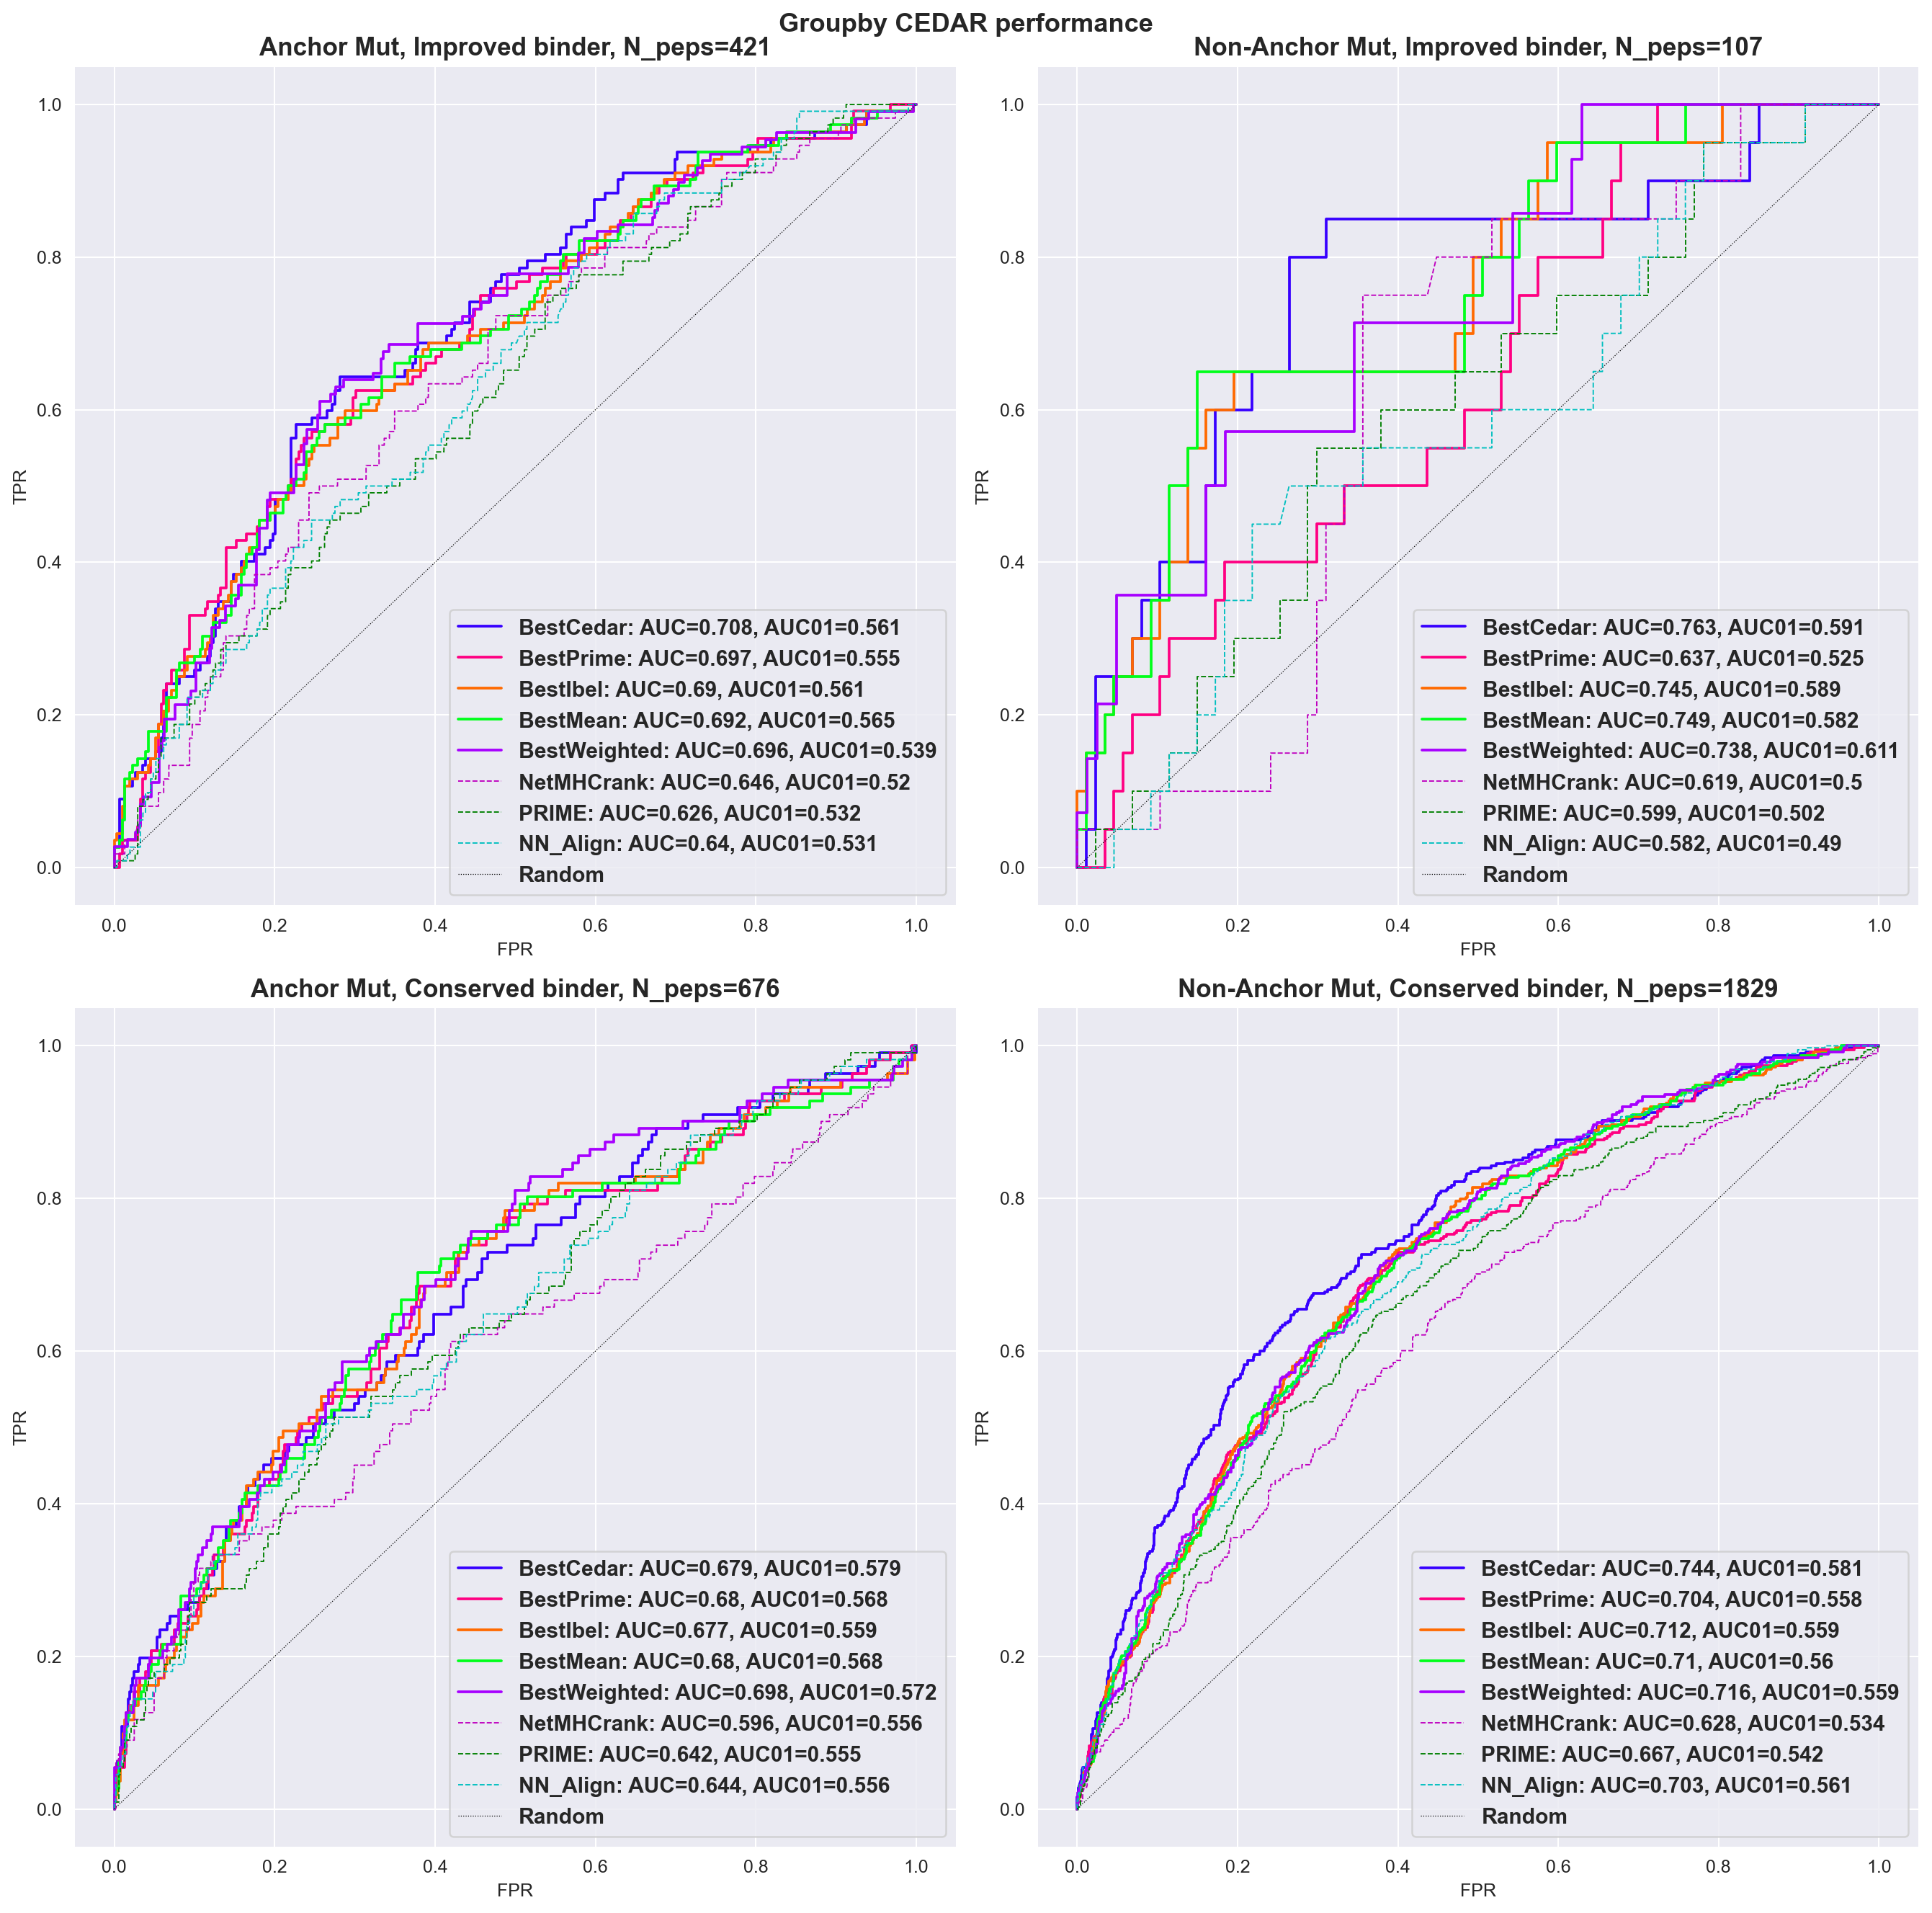

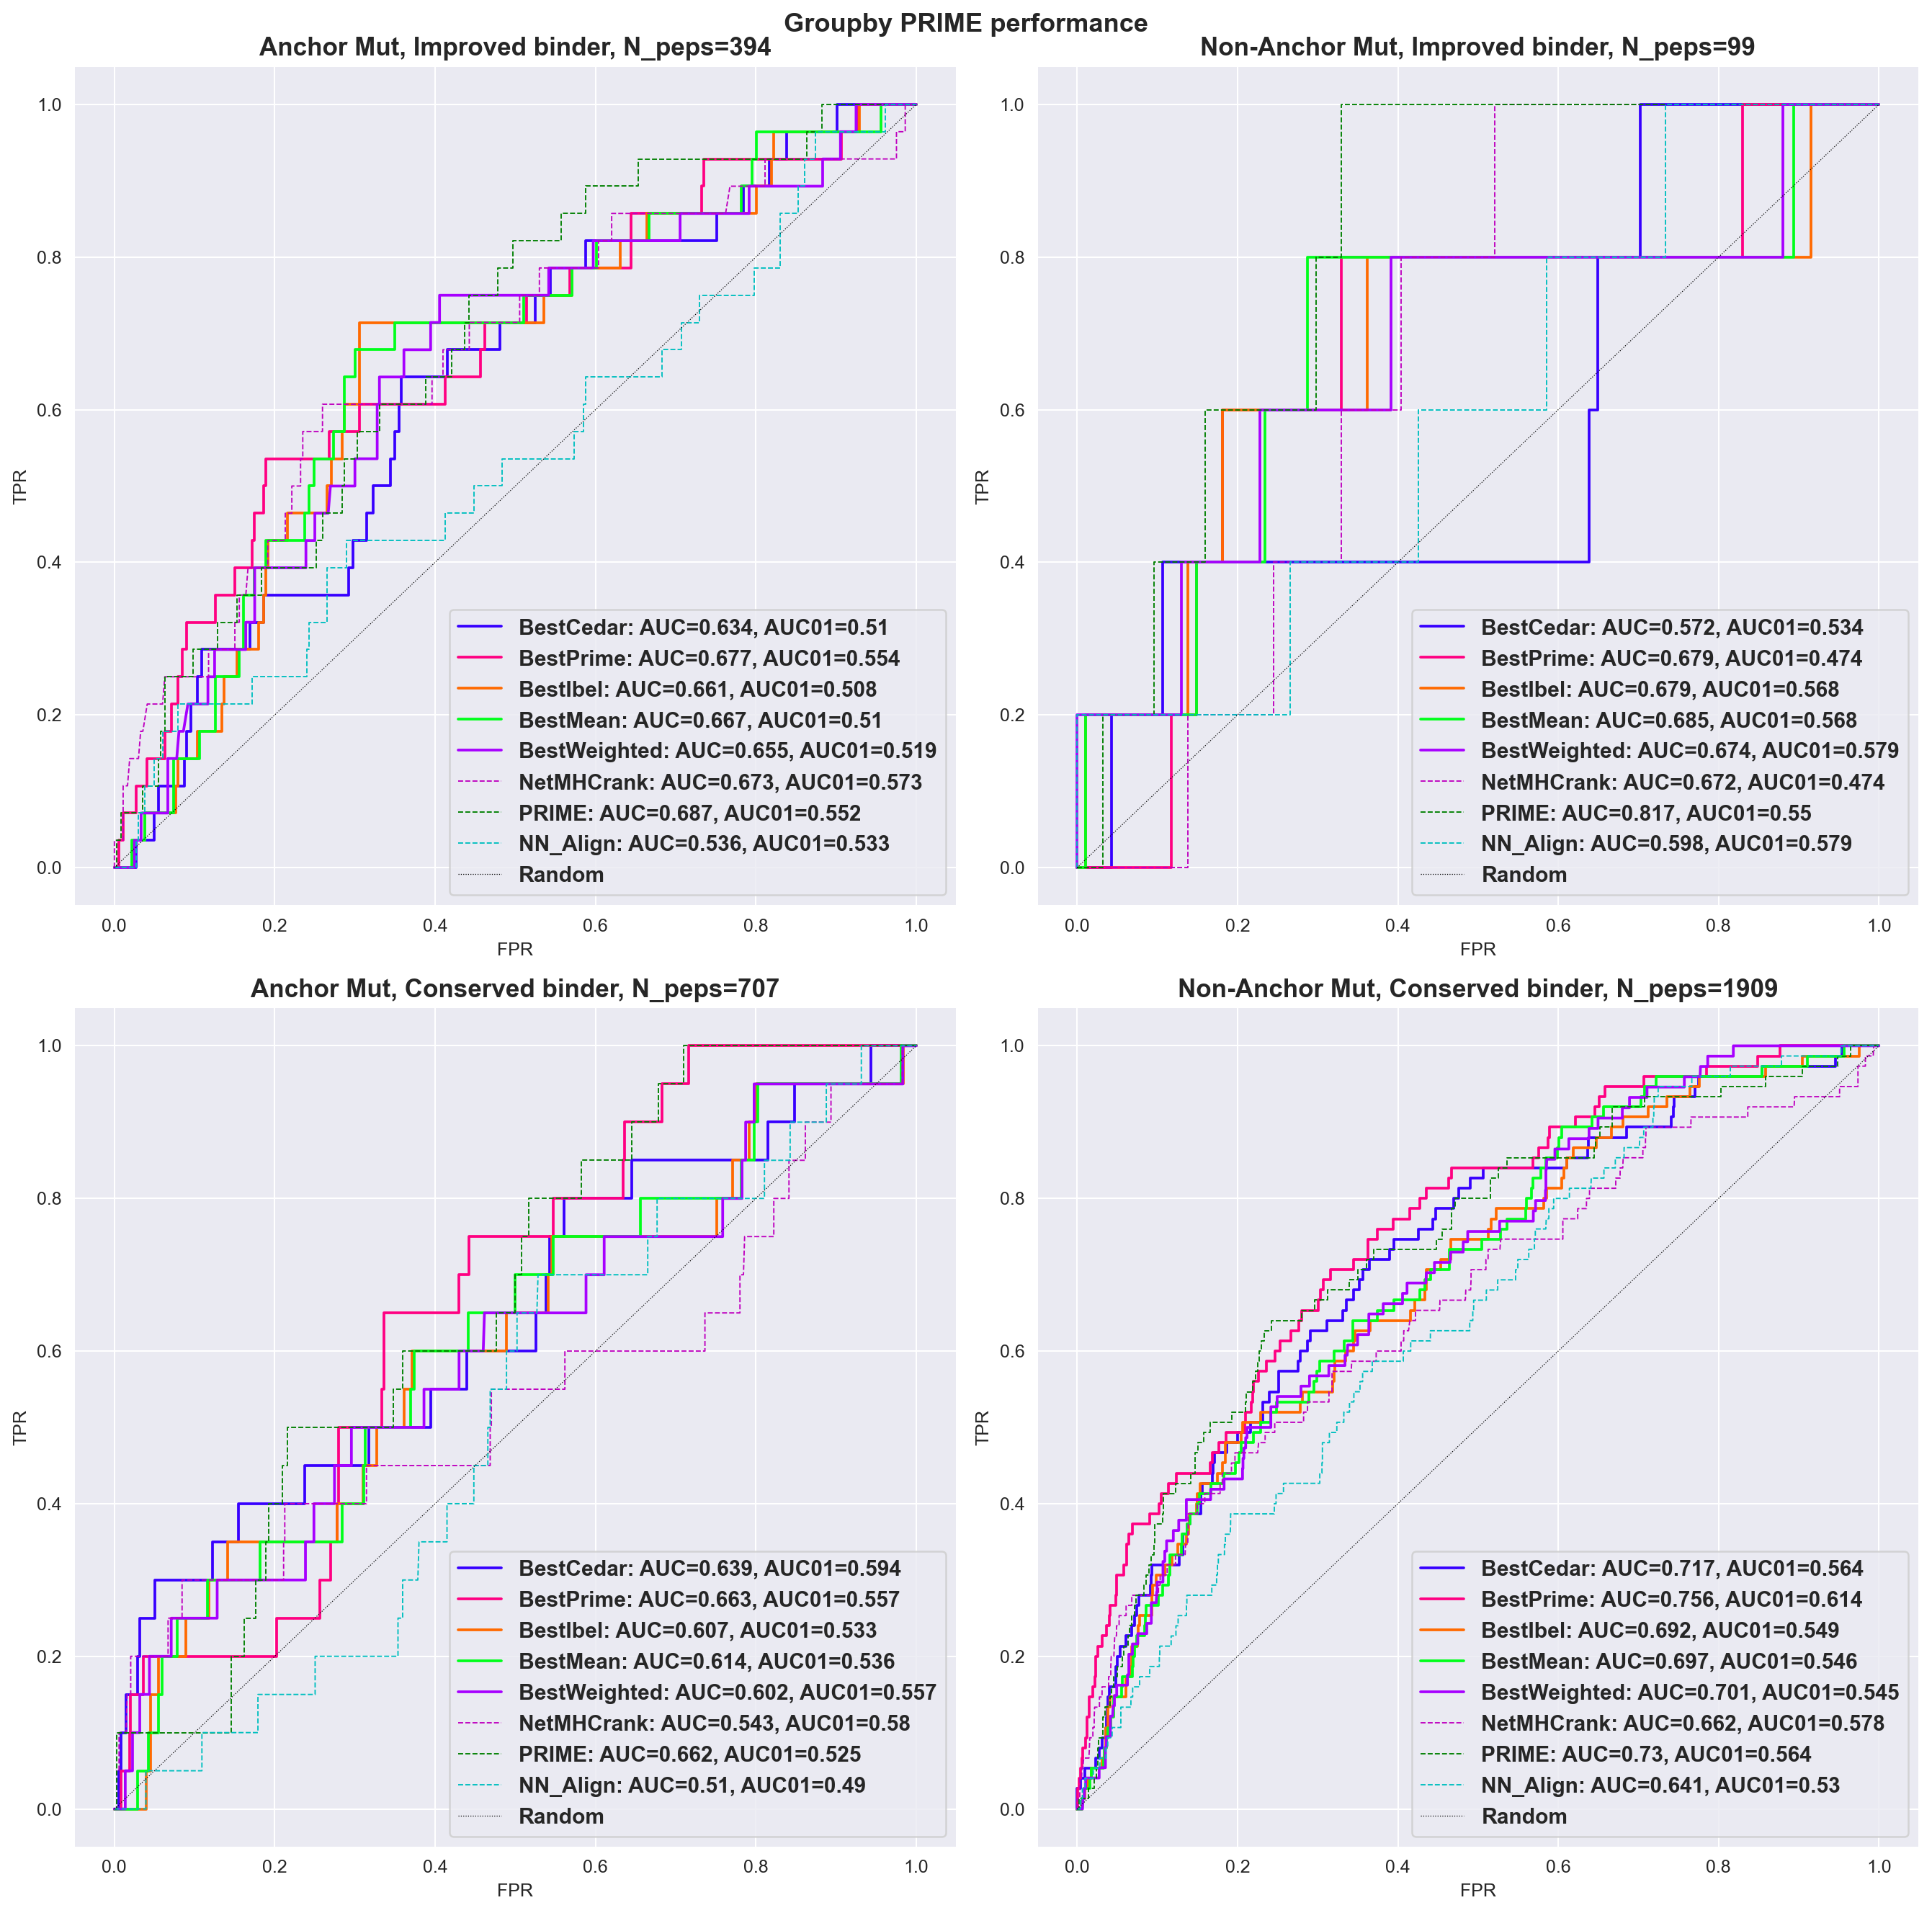

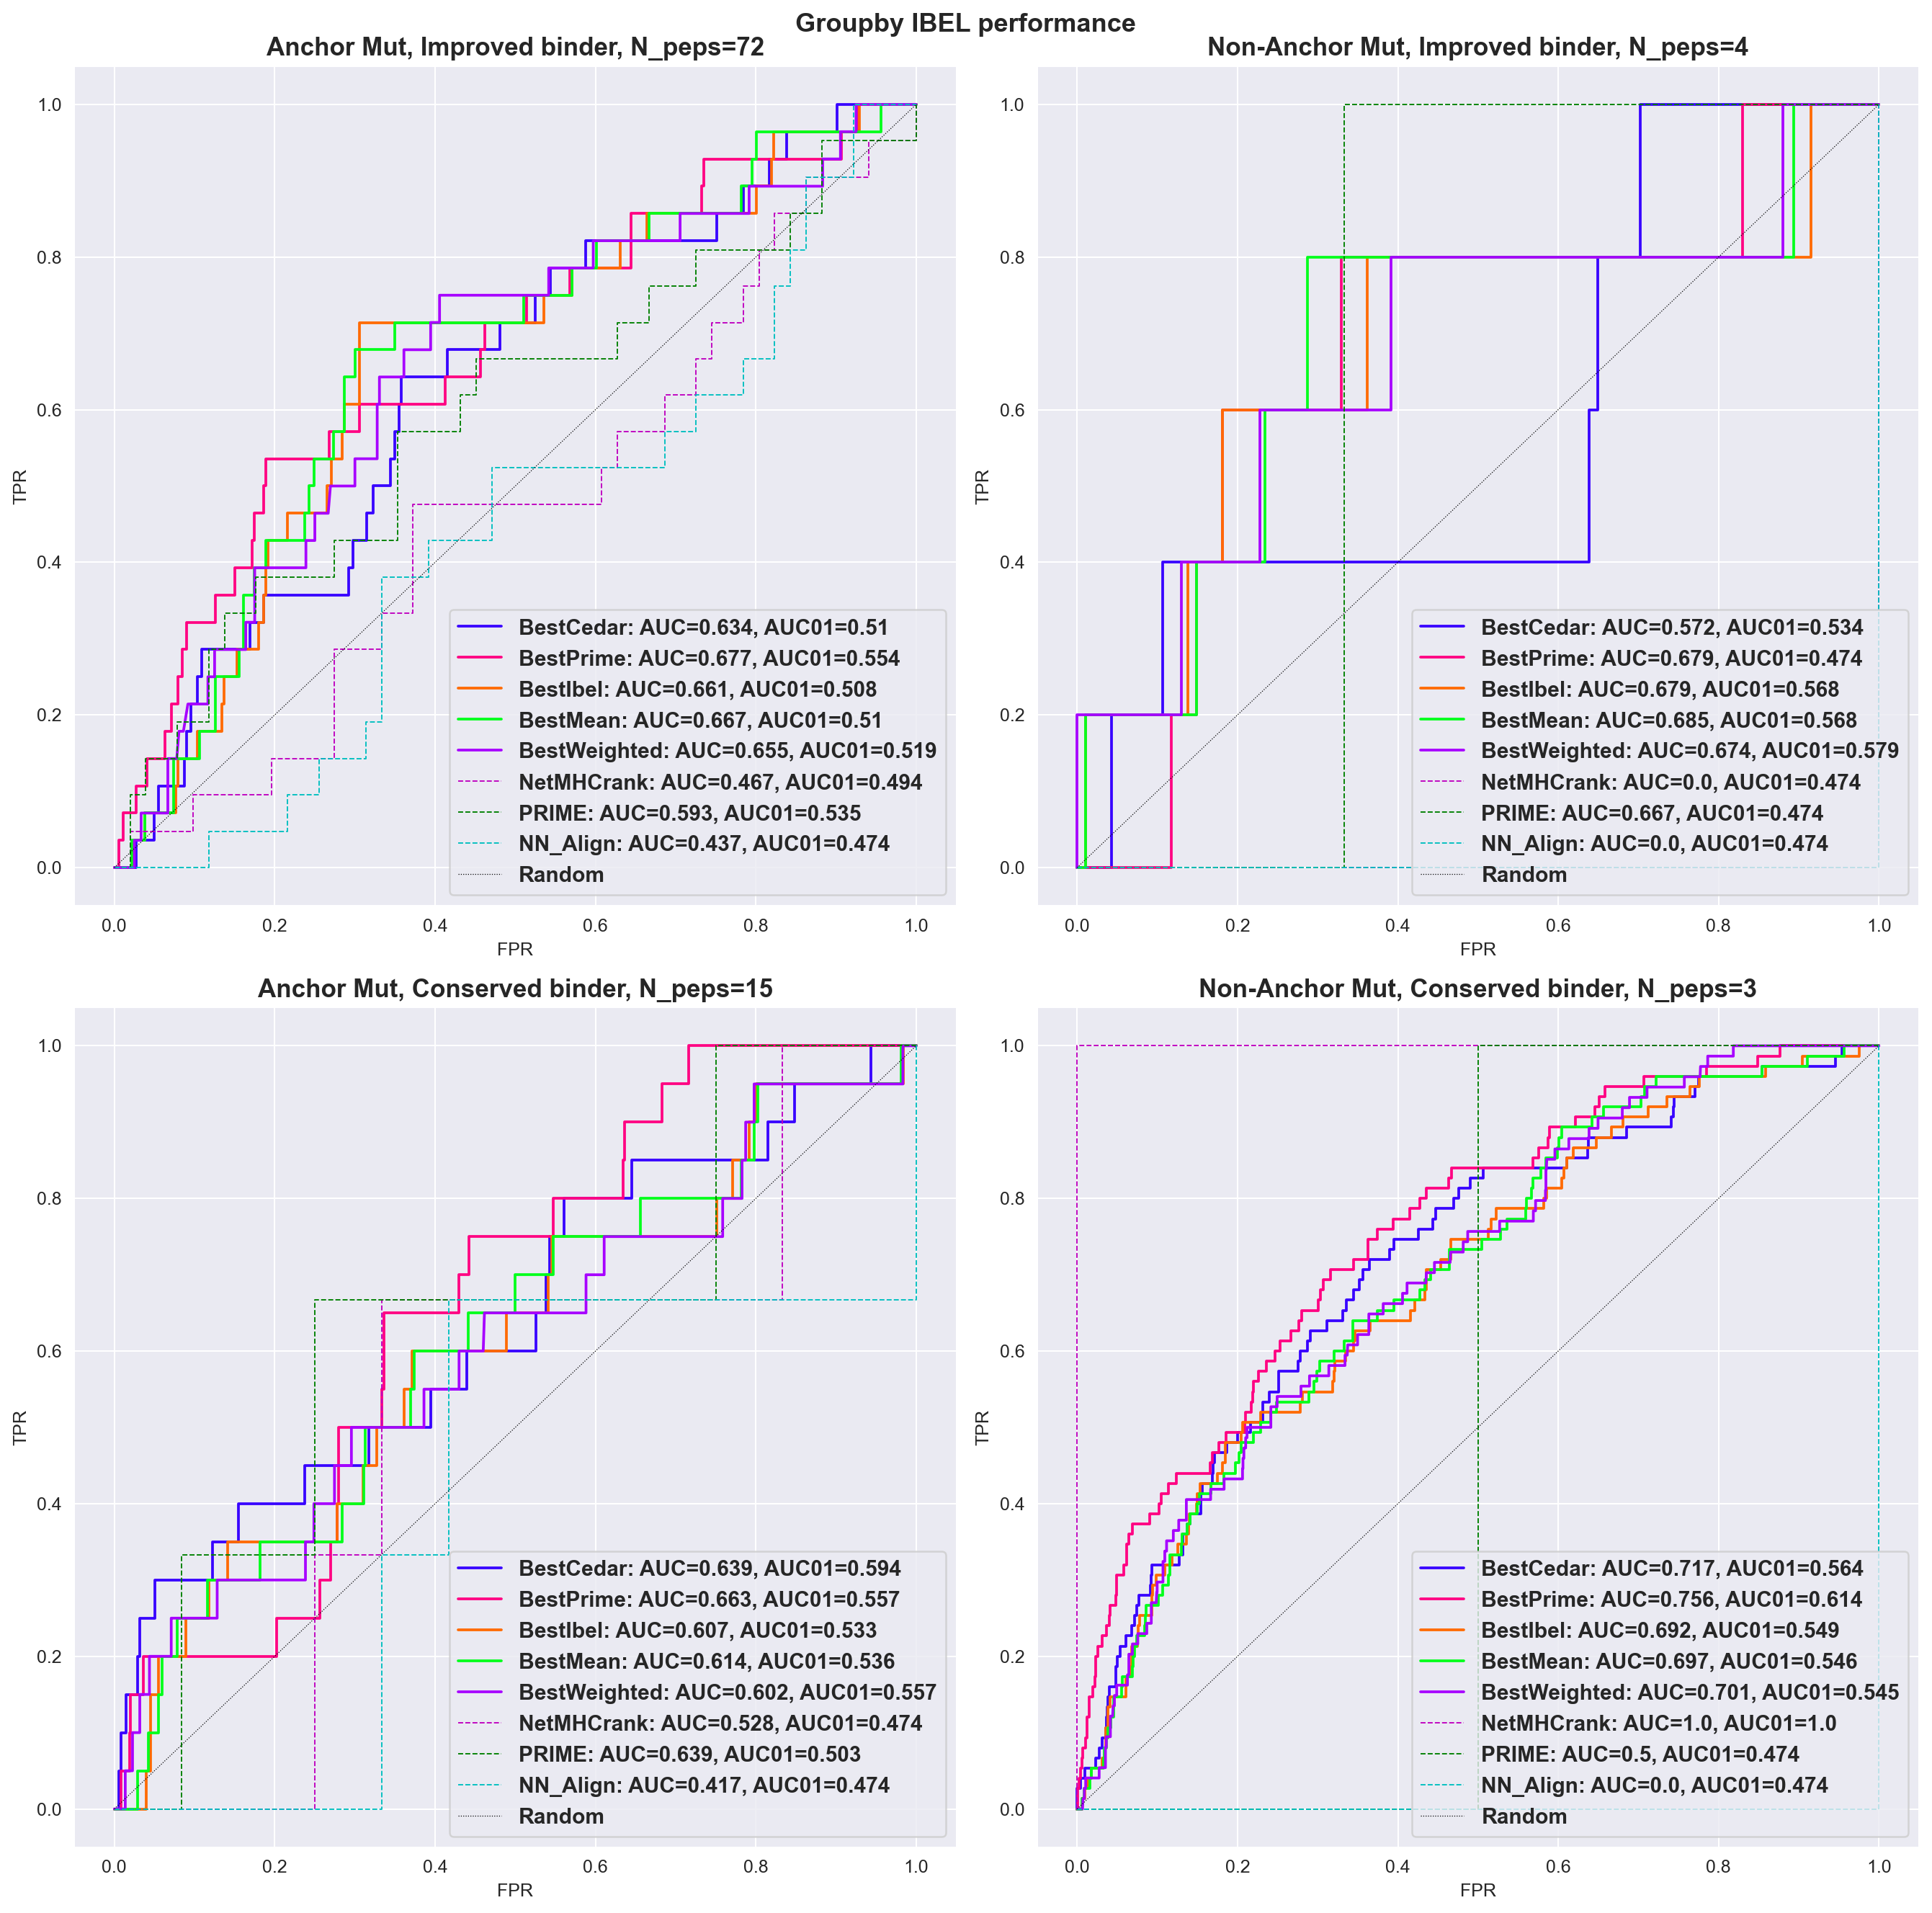

In [221]:
palette = HSV + [sns.color_palette('hsv', n_colors=13)[-3]]
sns.set_palette(palette)
f_cedar,a_cedar = plt.subplots(2,2, figsize= (15,15))
ax_cedar = a_cedar.ravel()

f_prime,a_prime = plt.subplots(2,2, figsize= (15,15))
ax_prime = a_prime.ravel()

f_ibel, a_ibel = plt.subplots(2,2, figsize= (15,15))
ax_ibel = a_ibel.ravel()
i=0
for binder in ['Improved', 'Conserved']:
    for anc in [True, False]:
        xd = 'Anchor Mut' if anc else 'Non-Anchor Mut'
        name = f'{xd}, {binder} binder'
        for k, df_ced, df_pr, df_ibel in zip(['BestCedar', 'BestPrime', 'BestIbel', 'BestMean', 'BestWeighted'],
                                            [best_cedar_cdt_cedar_preds, best_prime_cdt_cedar_preds, best_ibel_cdt_cedar_preds, best_mean_cdt_cedar_preds, best_weighted_cdt_cedar_preds],
                                            [best_cedar_cdt_prime_preds, best_prime_cdt_prime_preds, best_ibel_cdt_prime_preds, best_mean_cdt_prime_preds, best_weighted_cdt_prime_preds],
                                            [best_cedar_cdt_ibel_preds, best_prime_cdt_ibel_preds, best_ibel_cdt_ibel_preds, best_mean_cdt_ibel_preds, best_weighted_cdt_ibel_preds]):
            
            values_cedar = get_roc(df_ced, 'pred','agg_label',  binder, anc)
            sns.lineplot(x=values_cedar['roc'][0], y=values_cedar['roc'][1], label=f"{k}: AUC={round(values_cedar['auc'],3)}, AUC01={round(values_cedar['auc01'],3)}", 
                         estimator = None, ax=ax_cedar[i])
            ax_cedar[i].set_title(f"{name}, N_peps={len(cedar_related.query('anchor_mutation==@anc and binder==@binder'))}", fontweight='semibold', fontsize=14)
            ax_cedar[i].set_xlabel('FPR')
            ax_cedar[i].set_ylabel('TPR')
            
            values_prime = get_roc(df_pr, 'mean_pred', 'agg_label', binder, anc)
            sns.lineplot(x=values_prime['roc'][0], y=values_prime['roc'][1], label=f"{k}: AUC={round(values_prime['auc'],3)}, AUC01={round(values_prime['auc01'],3)}", 
                         estimator = None, ax=ax_prime[i])
            ax_prime[i].set_title(f"{name}, N_peps={len(prime_related.query('anchor_mutation==@anc and binder==@binder'))}", fontweight='semibold', fontsize=14)
            ax_prime[i].set_xlabel('FPR')
            ax_prime[i].set_ylabel('TPR')
            
            
            values_ibel = get_roc(df_pr, 'mean_pred', 'agg_label', binder, anc)
            sns.lineplot(x=values_ibel['roc'][0], y=values_ibel['roc'][1], label=f"{k}: AUC={round(values_ibel['auc'],3)}, AUC01={round(values_ibel['auc01'],3)}", 
                         estimator = None, ax=ax_ibel[i])
            ax_ibel[i].set_title(f"{name}, N_peps={len(ibel.query('anchor_mutation==@anc and binder==@binder'))}", fontweight='semibold', fontsize=14)
            ax_ibel[i].set_xlabel('FPR')
            ax_ibel[i].set_ylabel('TPR')
        
        plot_related_baseline_roc(ax_cedar[i], cedar_related_baseline, binder, anc, auc01=True)
        # ax_cedar[i].plot([0,1],[0,1], label = 'Random', ls=':', lw=0.5)
        plot_related_baseline_roc(ax_prime[i], prime_related_baseline ,binder, anc, auc01=True)
        plot_related_baseline_roc(ax_ibel[i], ibel, binder, anc, auc01=True)
        # ax_prime[i].plot([0,1],[0,1], label = 'Random', ls=':', lw=0.5)
        ax_cedar[i].legend(loc='lower right',  prop={'weight':'semibold', 'size':12})
        ax_prime[i].legend(loc='lower right',  prop={'weight':'semibold', 'size':12})
        f_cedar.suptitle('Groupby CEDAR performance', fontweight='semibold', fontsize=14.5)
        f_cedar.tight_layout()
        f_prime.suptitle('Groupby PRIME performance', fontweight='semibold', fontsize=14.5)
        f_prime.tight_layout()
        ax_ibel[i].legend(loc='lower right',  prop={'weight':'semibold', 'size':12})
        f_ibel.suptitle('Groupby IBEL performance', fontweight='semibold', fontsize=14.5)
        f_ibel.tight_layout()
        i+=1

Text(0, 0.5, 'TPR')

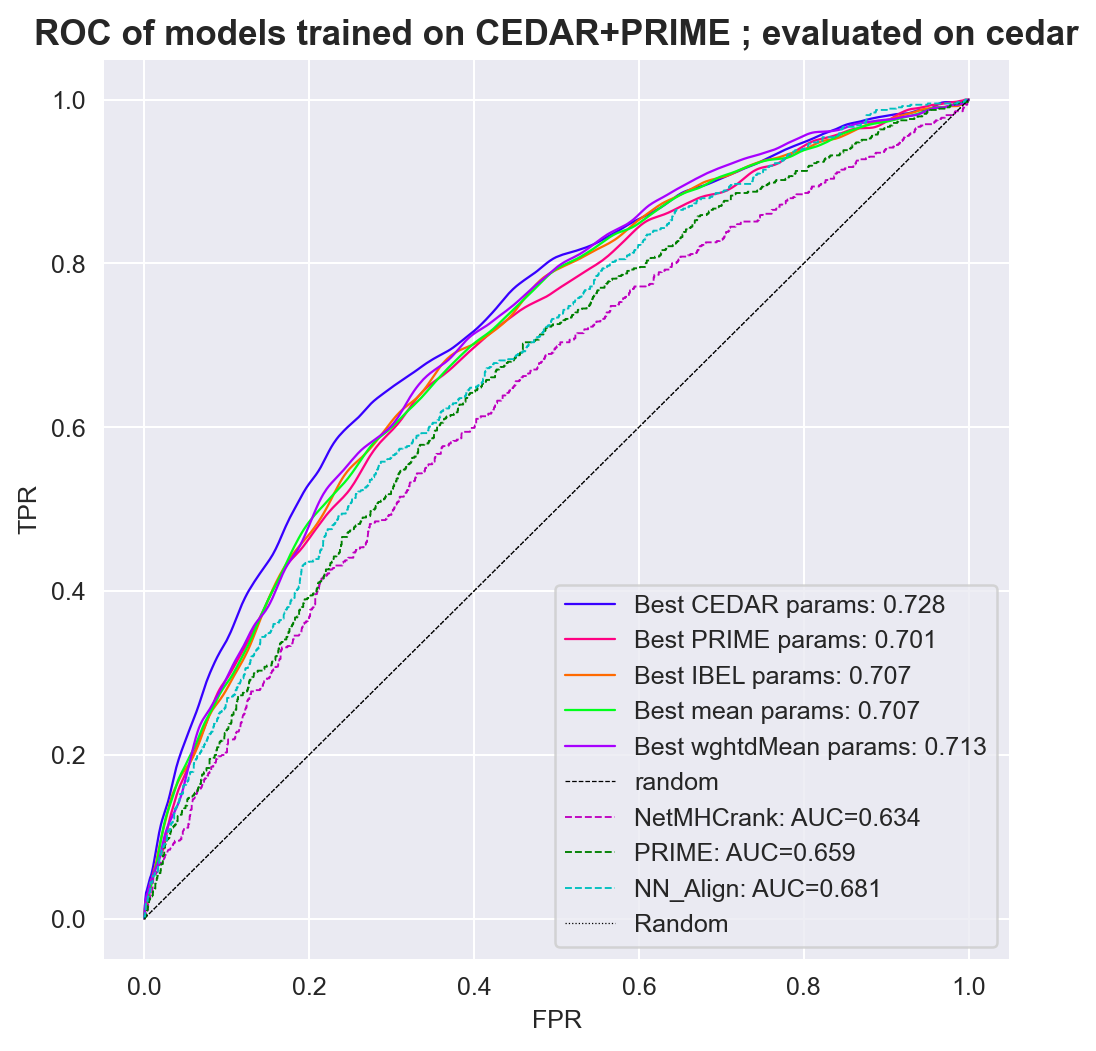

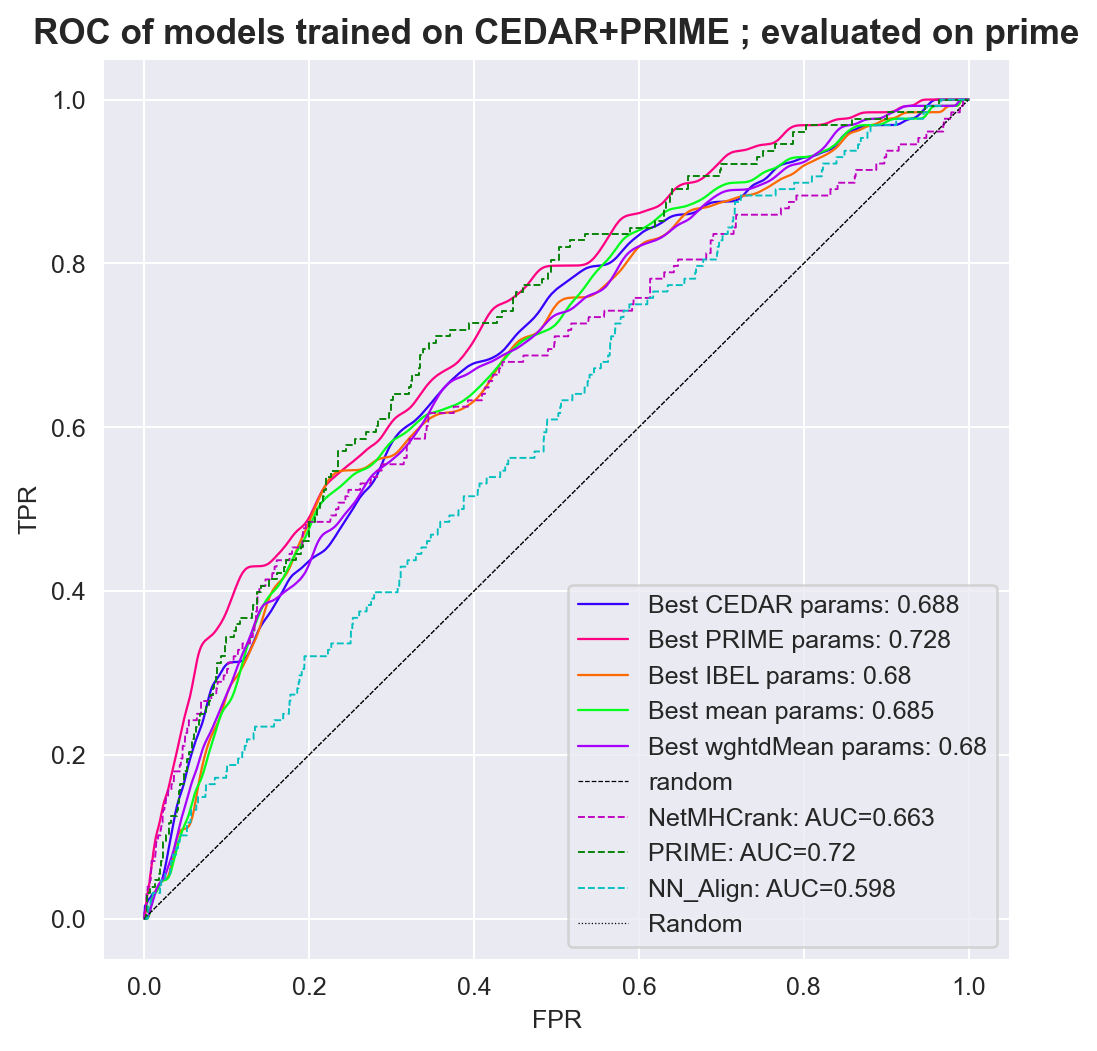

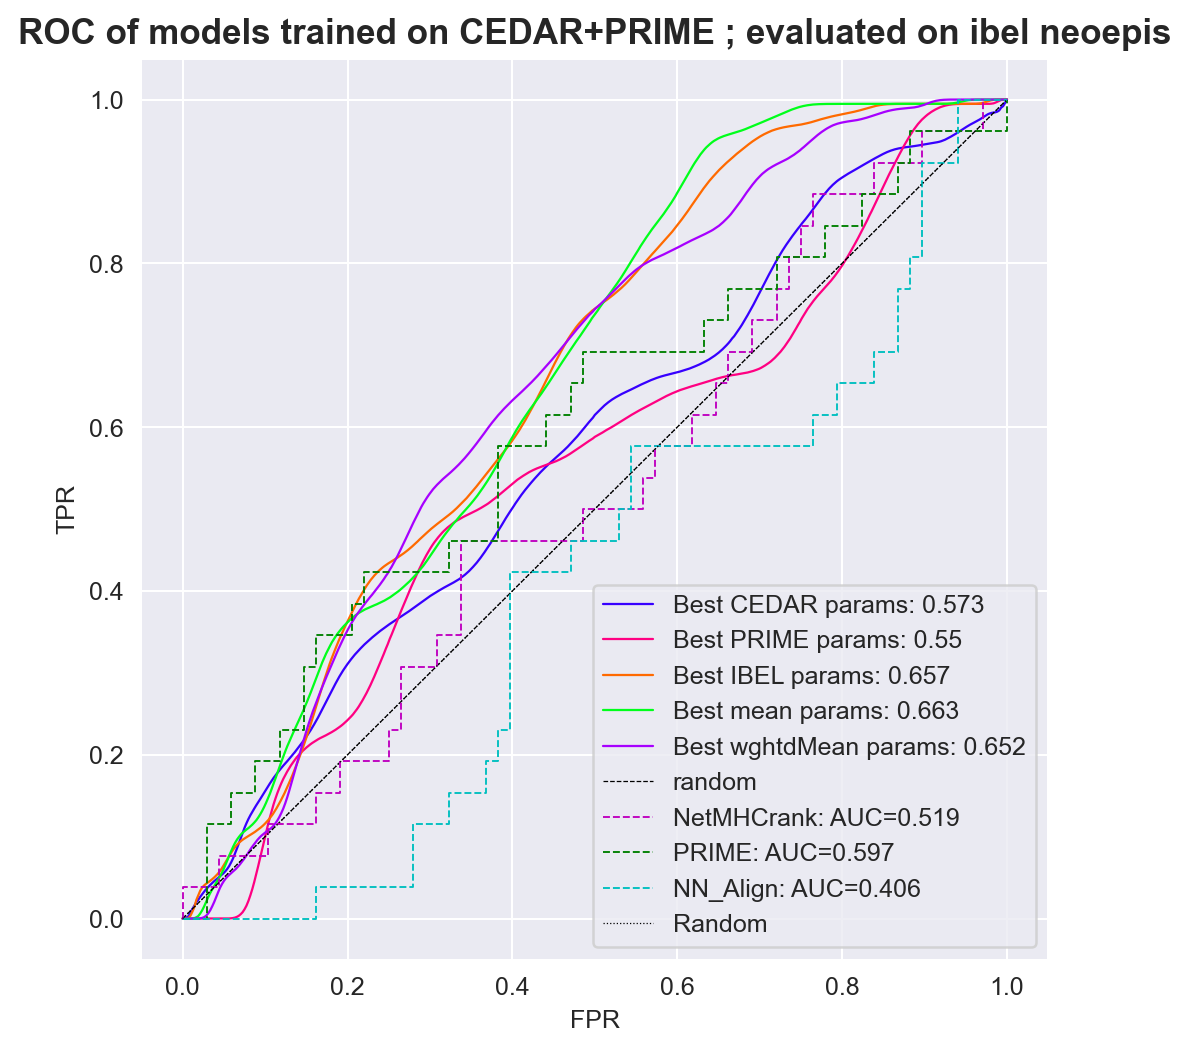

In [201]:
xd = HSV+[sns.color_palette('hsv', n_colors=13)[-3]]
sns.set_palette(xd)
f,a = plt.subplots(1,1, figsize=(6.5, 6.5))
# CEDAR roc
sns.lineplot(x=best_cedar_cdt_cedar_roc[0], y=best_cedar_cdt_cedar_roc[1], linewidth=0.9,
             label=f'Best CEDAR params: {round(best_cedar_cdt_cedar_roc[-1],3)}', ax=a)

sns.lineplot(x=best_prime_cdt_cedar_roc[0], y=best_prime_cdt_cedar_roc[1], linewidth=0.9,
             label=f'Best PRIME params: {round(best_prime_cdt_cedar_roc[-1],3)}', ax=a)

sns.lineplot(x=best_ibel_cdt_cedar_roc[0], y=best_ibel_cdt_cedar_roc[1], linewidth=0.9,
             label=f'Best IBEL params: {round(best_ibel_cdt_cedar_roc[-1],3)}', ax=a)

sns.lineplot(x=best_mean_cdt_cedar_roc[0], y=best_mean_cdt_cedar_roc[1], linewidth=0.9,
             label=f'Best mean params: {round(best_mean_cdt_cedar_roc[-1],3)}', ax=a)

sns.lineplot(x=best_weighted_cdt_cedar_roc[0], y=best_weighted_cdt_cedar_roc[1], linewidth=0.9,
             label=f'Best wghtdMean params: {round(best_weighted_cdt_cedar_roc[-1],3)}', ax=a)

a.plot([0,1],[0,1],ls='--',lw=0.5,c='k', label='random')
plot_related_baseline_roc(axis=a, dataset=cedar_related_baseline)
a.legend(loc='lower right')
a.set_title('ROC of models trained on CEDAR+PRIME ; evaluated on cedar', fontweight='semibold',fontsize=14)
a.set_xlabel('FPR')
a.set_ylabel('TPR')

# PRIME roc
f,a = plt.subplots(1,1, figsize=(6.5, 6.5))
sns.lineplot(x=best_cedar_cdt_prime_roc[0], y=best_cedar_cdt_prime_roc[1], linewidth=0.9,
             label=f'Best CEDAR params: {round(best_cedar_cdt_prime_roc[-1],3)}', ax=a)

sns.lineplot(x=best_prime_cdt_prime_roc[0], y=best_prime_cdt_prime_roc[1], linewidth=0.9,
             label=f'Best PRIME params: {round(best_prime_cdt_prime_roc[-1],3)}', ax=a)

sns.lineplot(x=best_ibel_cdt_prime_roc[0], y=best_ibel_cdt_prime_roc[1], linewidth=0.9,
             label=f'Best IBEL params: {round(best_ibel_cdt_prime_roc[-1],3)}', ax=a)

sns.lineplot(x=best_mean_cdt_prime_roc[0], y=best_mean_cdt_prime_roc[1], linewidth=0.9,
             label=f'Best mean params: {round(best_mean_cdt_prime_roc[-1],3)}', ax=a)

sns.lineplot(x=best_weighted_cdt_prime_roc[0], y=best_weighted_cdt_prime_roc[1], linewidth=0.9,
             label=f'Best wghtdMean params: {round(best_weighted_cdt_prime_roc[-1],3)}', ax=a)

a.plot([0,1],[0,1],ls='--',lw=0.5,c='k', label='random')
plot_related_baseline_roc(axis=a, dataset=prime_related_baseline)
a.legend(loc='lower right')
a.set_title('ROC of models trained on CEDAR+PRIME ; evaluated on prime', fontweight='semibold',fontsize=14)
a.set_xlabel('FPR')
a.set_ylabel('TPR')

# IBEL roc
f,a = plt.subplots(1,1, figsize=(6.5, 6.5))

sns.lineplot(x=best_cedar_cdt_ibel_roc[0], y=best_cedar_cdt_ibel_roc[1], linewidth=0.9,
             label=f'Best CEDAR params: {round(best_cedar_cdt_ibel_roc[-1],3)}', ax=a)

sns.lineplot(x=best_prime_cdt_ibel_roc[0], y=best_prime_cdt_ibel_roc[1], linewidth=0.9,
             label=f'Best PRIME params: {round(best_prime_cdt_ibel_roc[-1],3)}', ax=a)

sns.lineplot(x=best_ibel_cdt_ibel_roc[0], y=best_ibel_cdt_ibel_roc[1], linewidth=0.9,
             label=f'Best IBEL params: {round(best_ibel_cdt_ibel_roc[-1],3)}', ax=a)

sns.lineplot(x=best_mean_cdt_ibel_roc[0], y=best_mean_cdt_ibel_roc[1], linewidth=0.9,
             label=f'Best mean params: {round(best_mean_cdt_ibel_roc[-1],3)}', ax=a)

sns.lineplot(x=best_weighted_cdt_ibel_roc[0], y=best_weighted_cdt_ibel_roc[1], linewidth=0.9,
             label=f'Best wghtdMean params: {round(best_weighted_cdt_ibel_roc[-1],3)}', ax=a)

a.plot([0,1],[0,1],ls='--',lw=0.5,c='k', label='random')
plot_related_baseline_roc(axis=a, dataset=ibel)
a.legend(loc='lower right')
a.set_title('ROC of models trained on CEDAR+PRIME ; evaluated on ibel neoepis', fontweight='semibold',fontsize=14)
a.set_xlabel('FPR')
a.set_ylabel('TPR')


## Initial boxplot (Encoding vs Input) 

Text(0.5, 1.0, 'Test AUC (PRIME) for all conditions\nGrouped by Encoding & Input method (Peptide vs ICORE)')

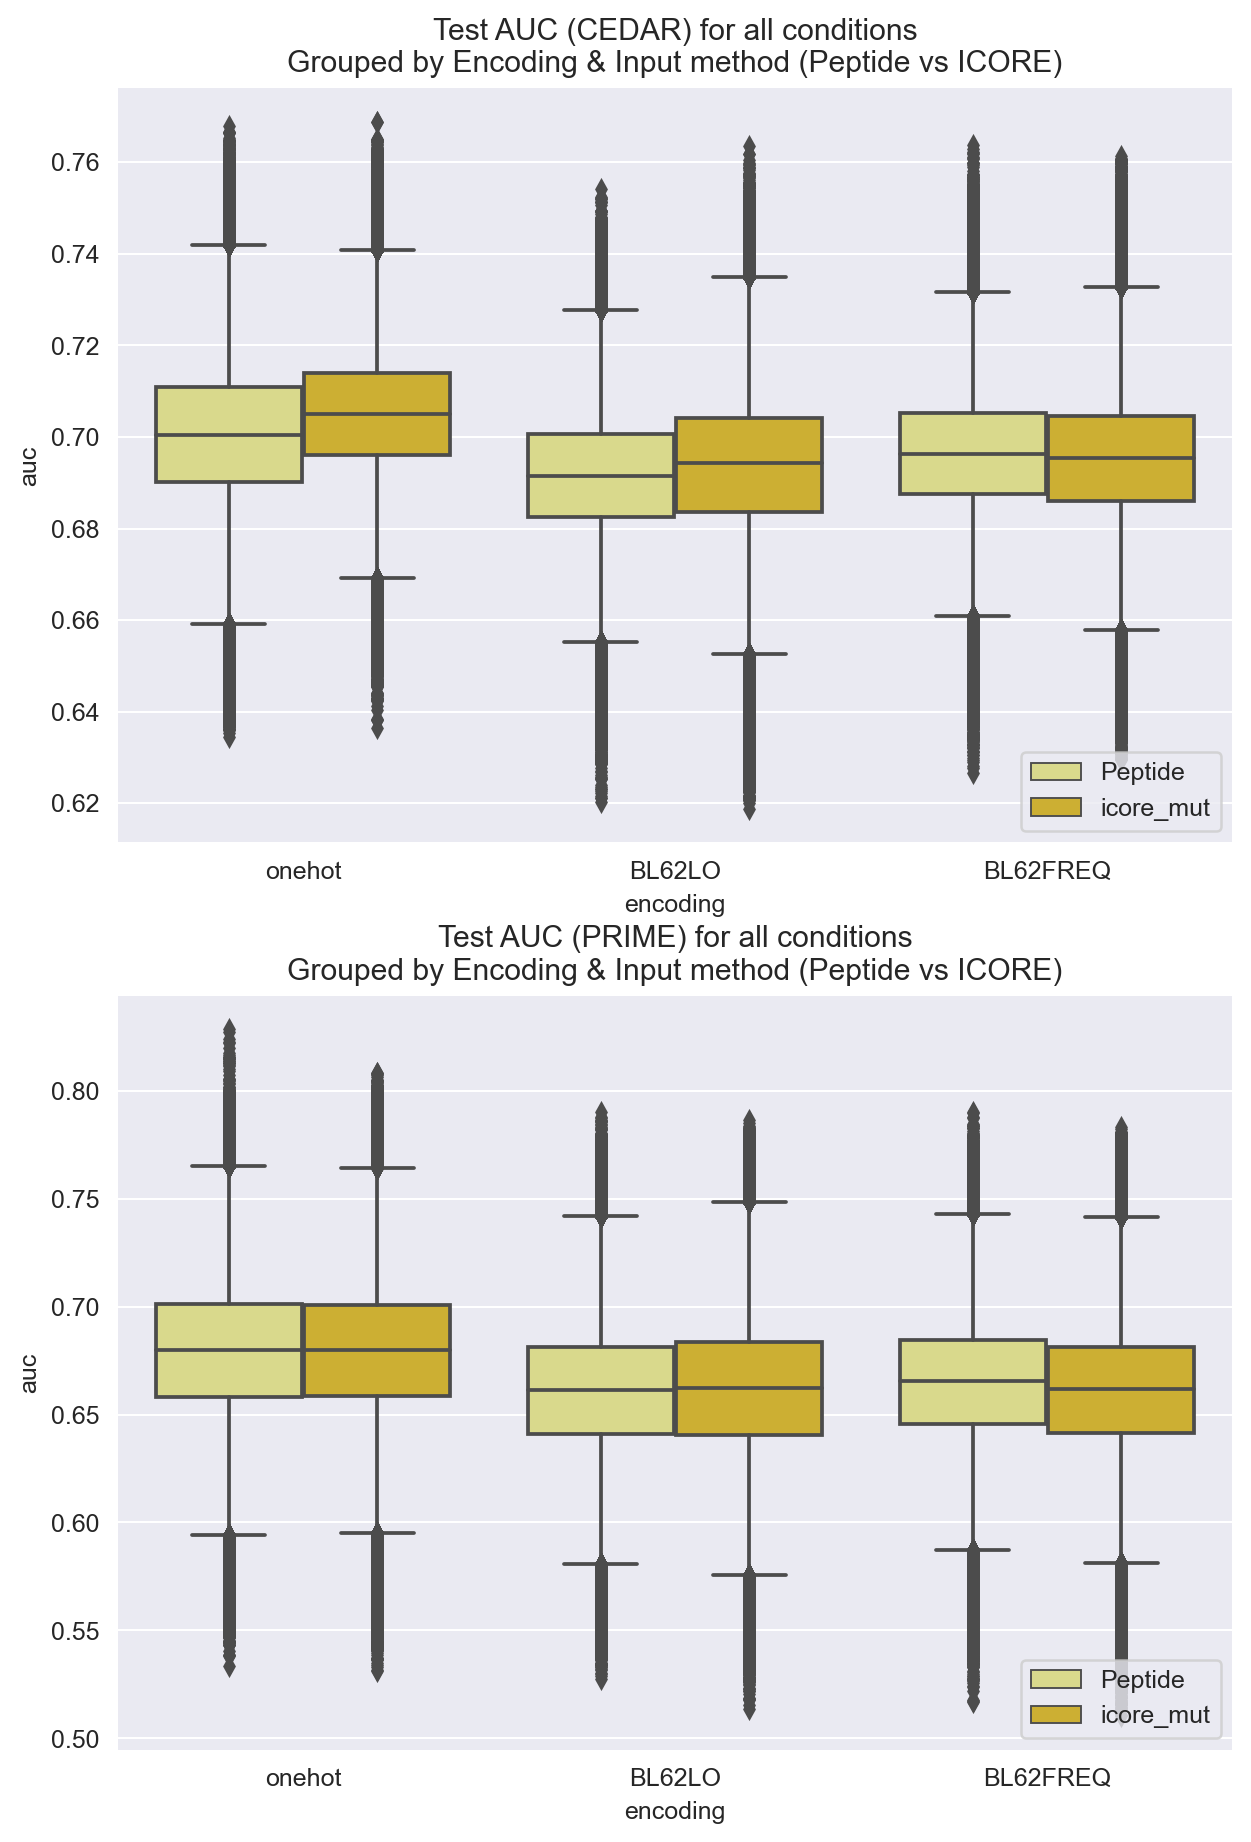

In [204]:
f,a = plt.subplots(2,1, figsize=(8,12))
tmp_ = df_results.query('evalset=="CEDAR"')
sns.boxplot(data=tmp_, hue='pep_col', x='encoding', y='auc', ax=a[0])
plt.setp(a[0].collections, alpha=.75)
a[0].legend(loc='lower right')
a[0].set_title('Test AUC (CEDAR) for all conditions\nGrouped by Encoding & Input method (Peptide vs ICORE)')

tmp_ = df_results.query('evalset=="PRIME"')
sns.boxplot(data=tmp_, hue='pep_col', x='encoding', y='auc', ax=a[1])
plt.setp(a[1].collections, alpha=.75)
a[1].legend(loc='lower right')
a[1].set_title('Test AUC (PRIME) for all conditions\nGrouped by Encoding & Input method (Peptide vs ICORE)')

## checking weights for OneHot encoding

In [148]:
order = ['KL', 'Shannon', 'Mask', 'None', 'Inverted Mask', 'Inverted Shannon', 'Inverted KL']
renamed_order = list(map(weight_name, order))

In [150]:
renamed_order

['(1–IC) KL',
 '(1–IC) Shannon',
 '(1–IC) Mask',
 'None',
 'IC Mask',
 'IC Shanno',
 'IC KL']

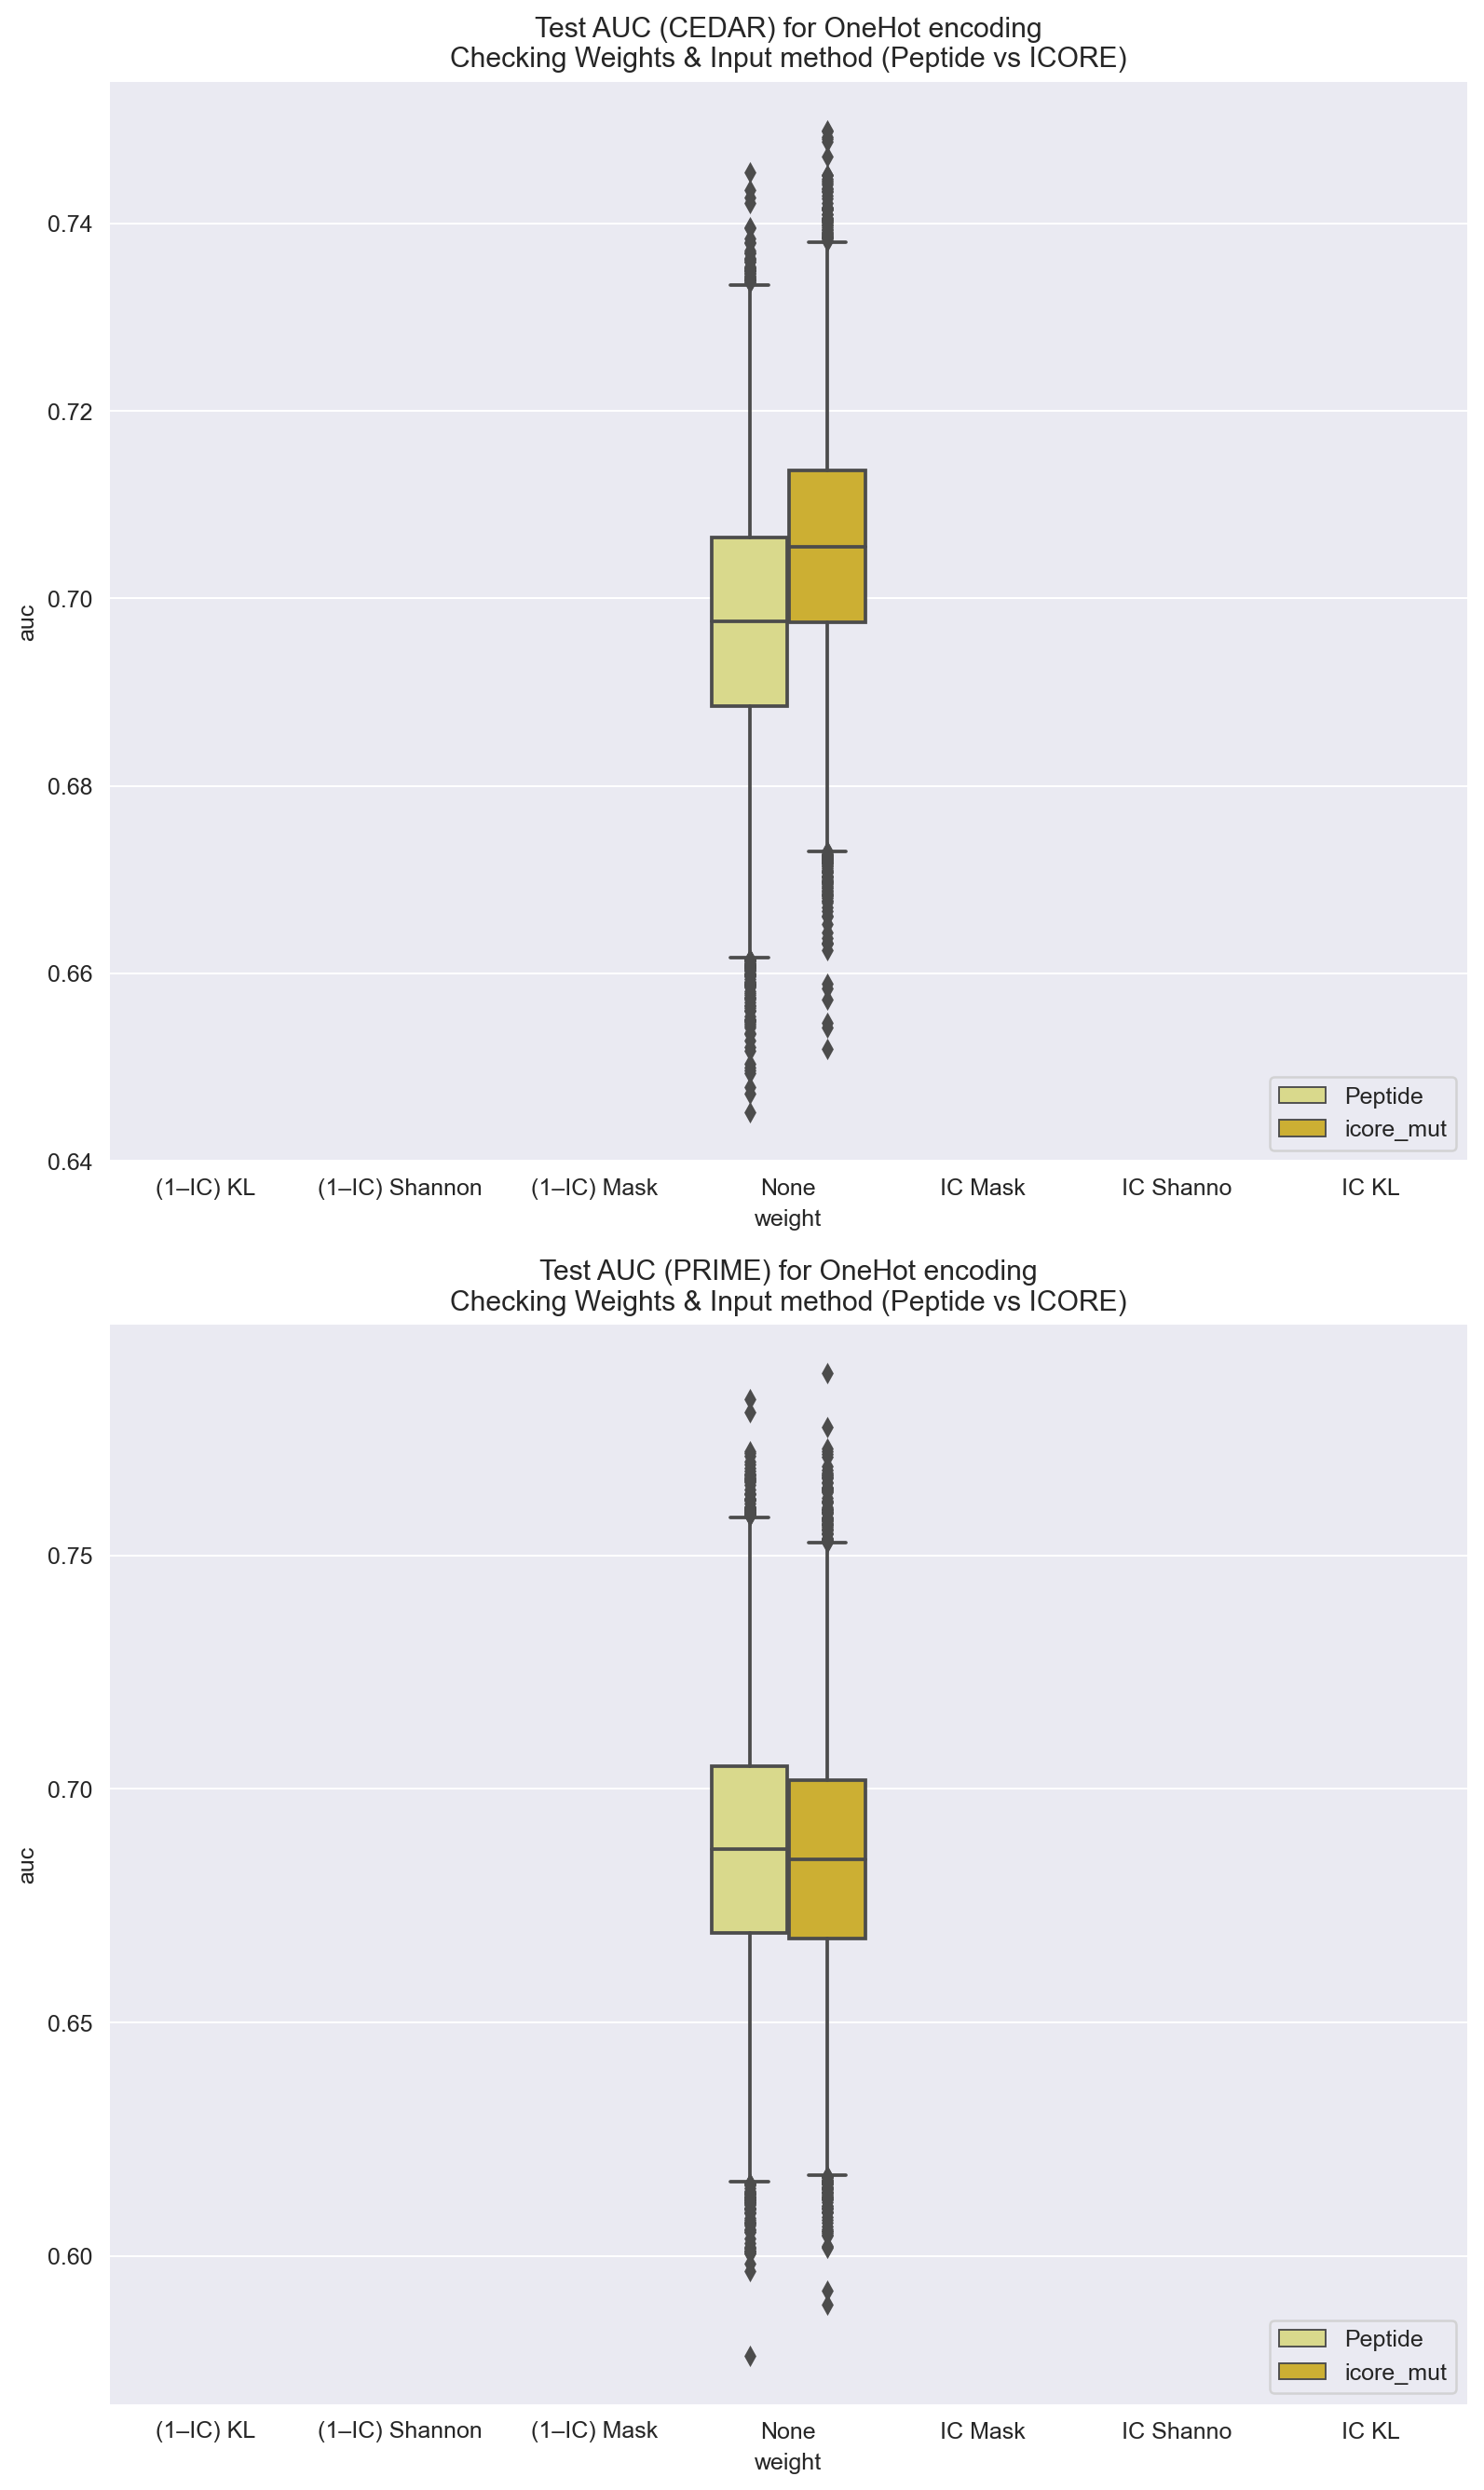

In [203]:
f,a = plt.subplots(2,1, figsize=(9,15))


tmp_ = df_results.query('evalset=="CEDAR" and encoding=="onehot" and key=="only_rank"')
sns.boxplot(data=tmp_, hue='pep_col', x='weight', y='auc', ax=a[0], order=renamed_order)
plt.setp(a[0].collections, alpha=.75)
a[0].legend(loc='lower right')
a[0].set_title('Test AUC (CEDAR) for OneHot encoding\nChecking Weights & Input method (Peptide vs ICORE)')

tmp_ = df_results.query('evalset=="PRIME" and encoding=="onehot" and key=="only_rank"')
sns.boxplot(data=tmp_, hue='pep_col', x='weight', y='auc', ax=a[1], order=renamed_order)
plt.setp(a[1].collections, alpha=.75)
a[1].legend(loc='lower right')
a[1].set_title('Test AUC (PRIME) for OneHot encoding\nChecking Weights & Input method (Peptide vs ICORE)')

f.tight_layout(pad=1.25)

## Feature columns / scores

In [434]:
df_reshape.columns

Index(['auc_cedar', 'prauc_cedar', 'AP_cedar', 'auc_01_cedar', 'f1_cedar',
       'accuracy_cedar', 'precision_cedar', 'recall_cedar', 'encoding',
       'weight', 'pep_col', 'rank_col', 'key', 'auc_prime', 'prauc_prime',
       'AP_prime', 'auc_01_prime', 'f1_prime', 'accuracy_prime',
       'precision_prime', 'recall_prime'],
      dtype='object')

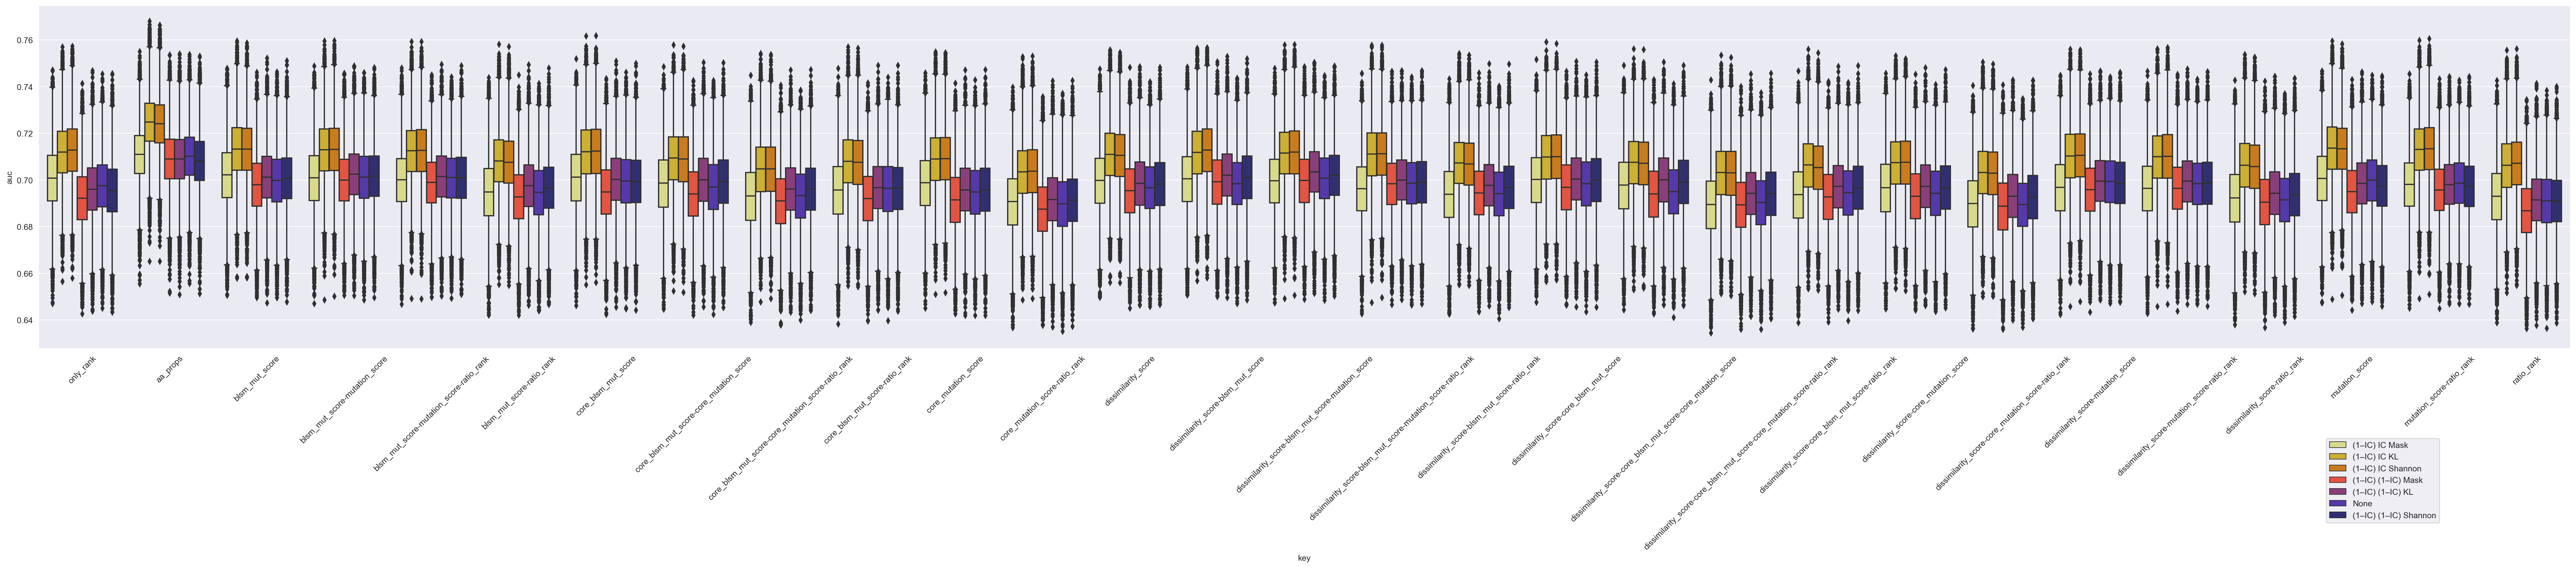

In [202]:
f,a = plt.subplots(1,1, figsize=(55,7.5))
cmr_pal = sns.color_palette('CMRmap_r', 7)
sns.set_palette(cmr_pal)
tmp_ = df_results.query('evalset=="CEDAR" and encoding=="onehot" and pep_col=="Peptide"')
sns.boxplot(data=tmp_, x = 'key', hue = 'weight', y = 'auc')
a.set_xticklabels(a.get_xticklabels(), rotation=45)
a.legend(bbox_to_anchor=(0.95, -0.25))

## Only look at weights that are IC shannon or IC KL as they are the top (group them together)

In [31]:
from copy import deepcopy
keys = df_reshape.key.unique()
mut_keys = [x for x in keys if 'mut' in x]
base_keys = [x for x in keys if x not in mut_keys]
core_keys = deepcopy(base_keys)
core_keys.extend([x for x in mut_keys if "core_" in x])
non_core_keys = deepcopy(base_keys)
non_core_keys.extend([x for x in mut_keys if "core_" not in x])

In [32]:
len(core_keys), len(non_core_keys), len(keys)

(17, 17, 29)

### Doing for stuff that works for CEDAR

In [475]:
tmp_core = df_results.query('(weight=="IC KL" or weight=="IC Shannon") and encoding=="onehot" and rank_col=="EL_rank_mut" and pep_col=="icore_mut" and key in @core_keys')
tmp_non = df_results.query('(weight=="IC KL" or weight=="IC Shannon") and encoding=="onehot" and rank_col=="EL_rank_mut" and pep_col=="Peptide" and key in @non_core_keys')

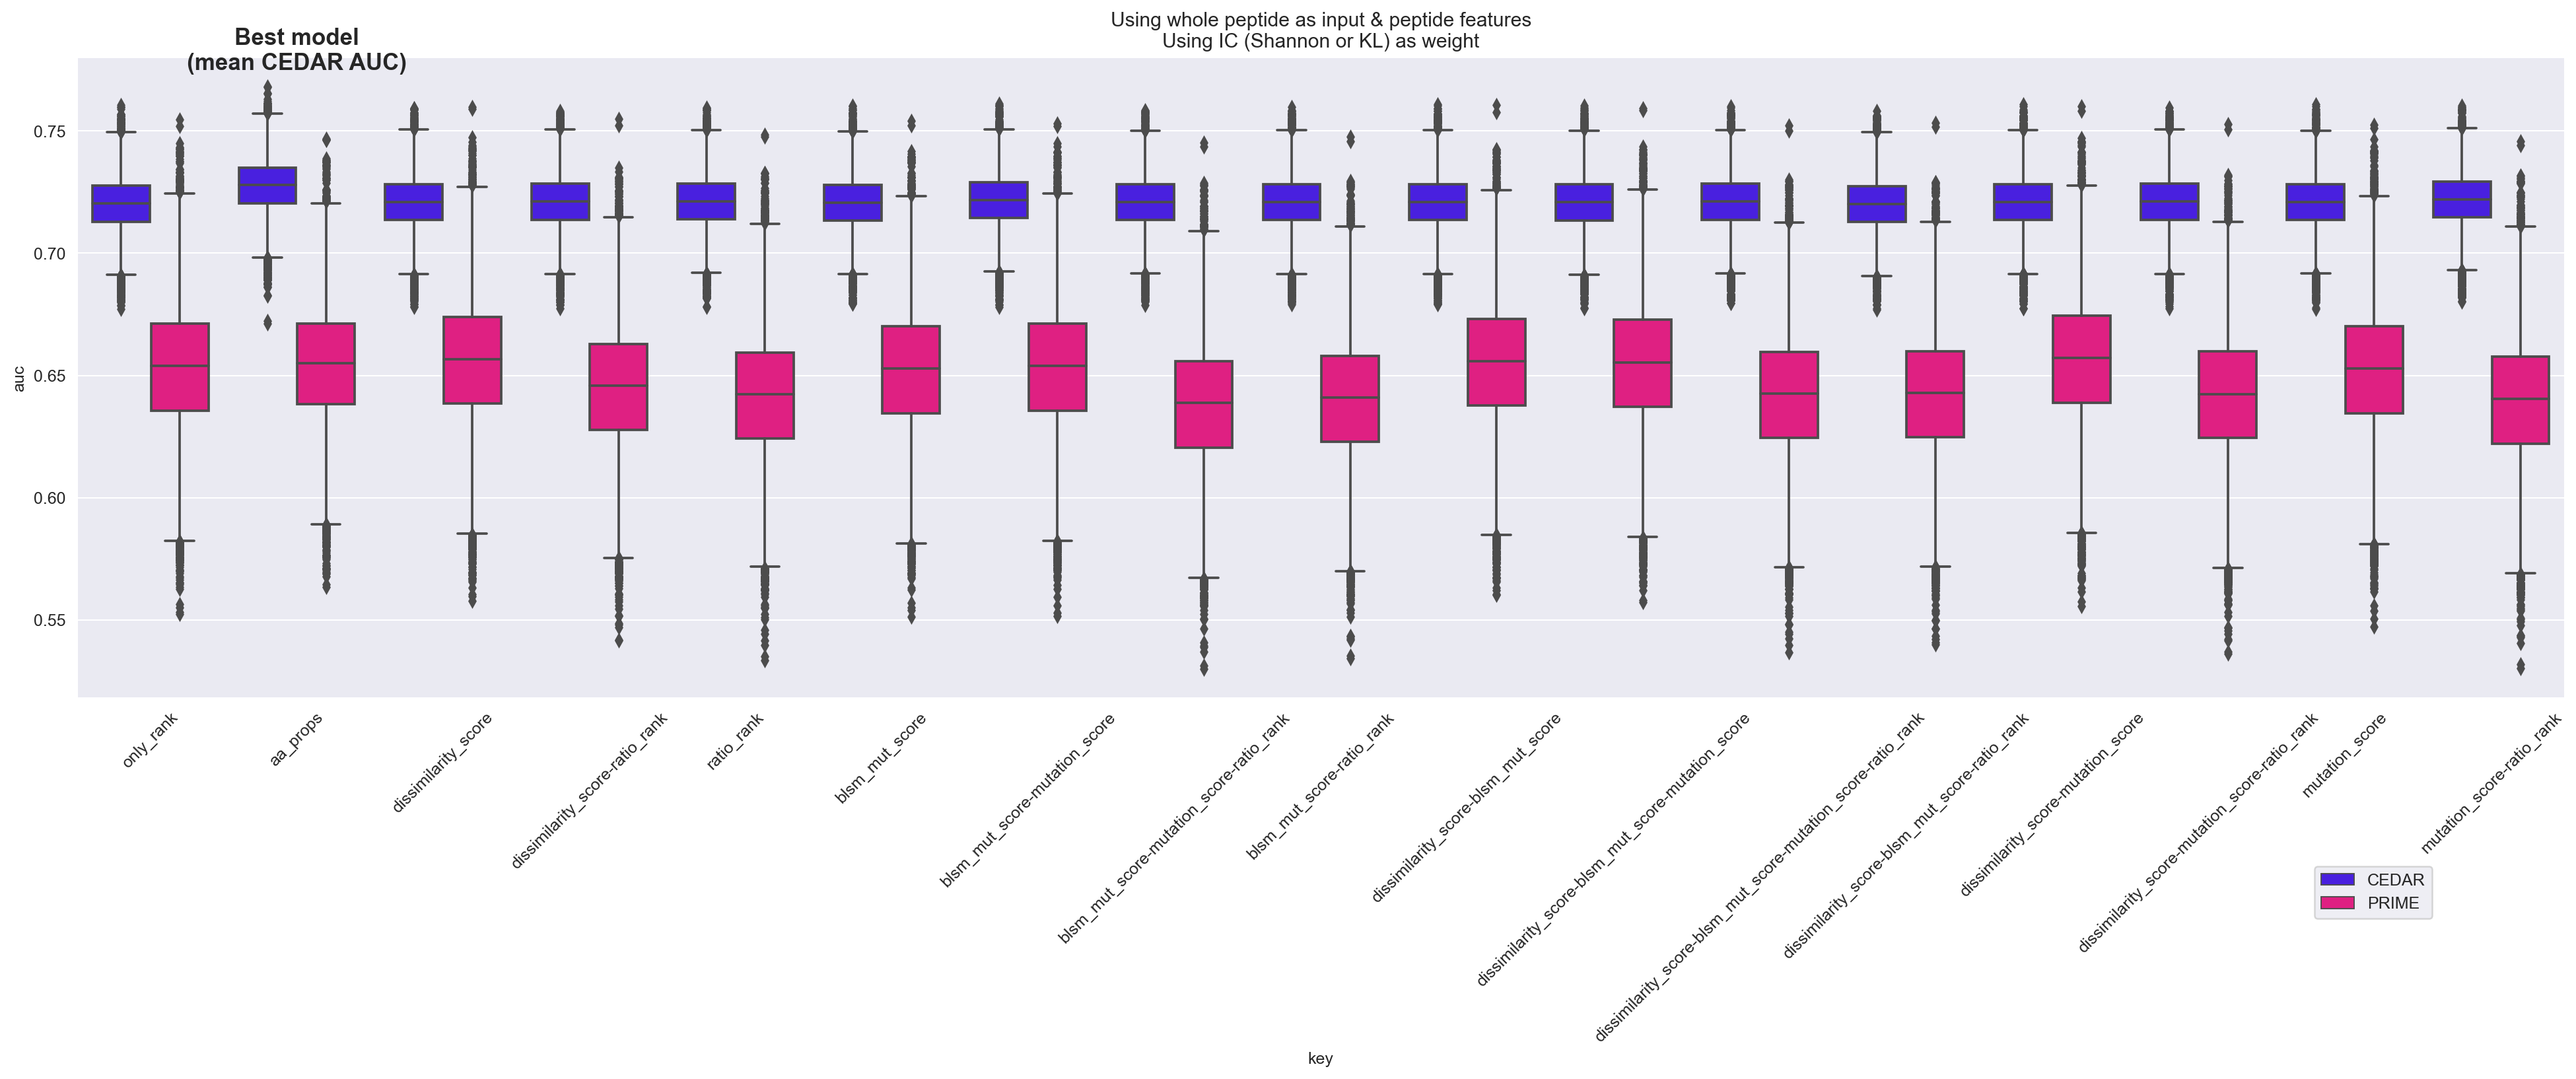

In [519]:
sns.set_palette(HSV)
f,a =plt.subplots(1,1, figsize=(27, 7))
sns.boxplot(data=tmp_non, x = 'key', hue = 'evalset', y = 'auc', order=non_core_keys)
a.set_xticklabels(a.get_xticklabels(), rotation=45)
plt.setp(a.collections, alpha=0.75)
a.set_title('Using whole peptide as input & peptide features\nUsing IC (Shannon or KL) as weight')

max_name = tmp_non.query('evalset=="CEDAR"').groupby('key').agg(mean_AUC=('auc','mean')).sort_values('mean_AUC', ascending=False).iloc[0].name
max_idx = non_core_keys.index(max_name)
a.text(max_idx, 0.775, "Best model\n(mean CEDAR AUC)", fontdict={'fontweight':'semibold', 'fontsize':14, 'horizontalalignment':'center'})
a.legend(bbox_to_anchor=(0.95, -0.25))

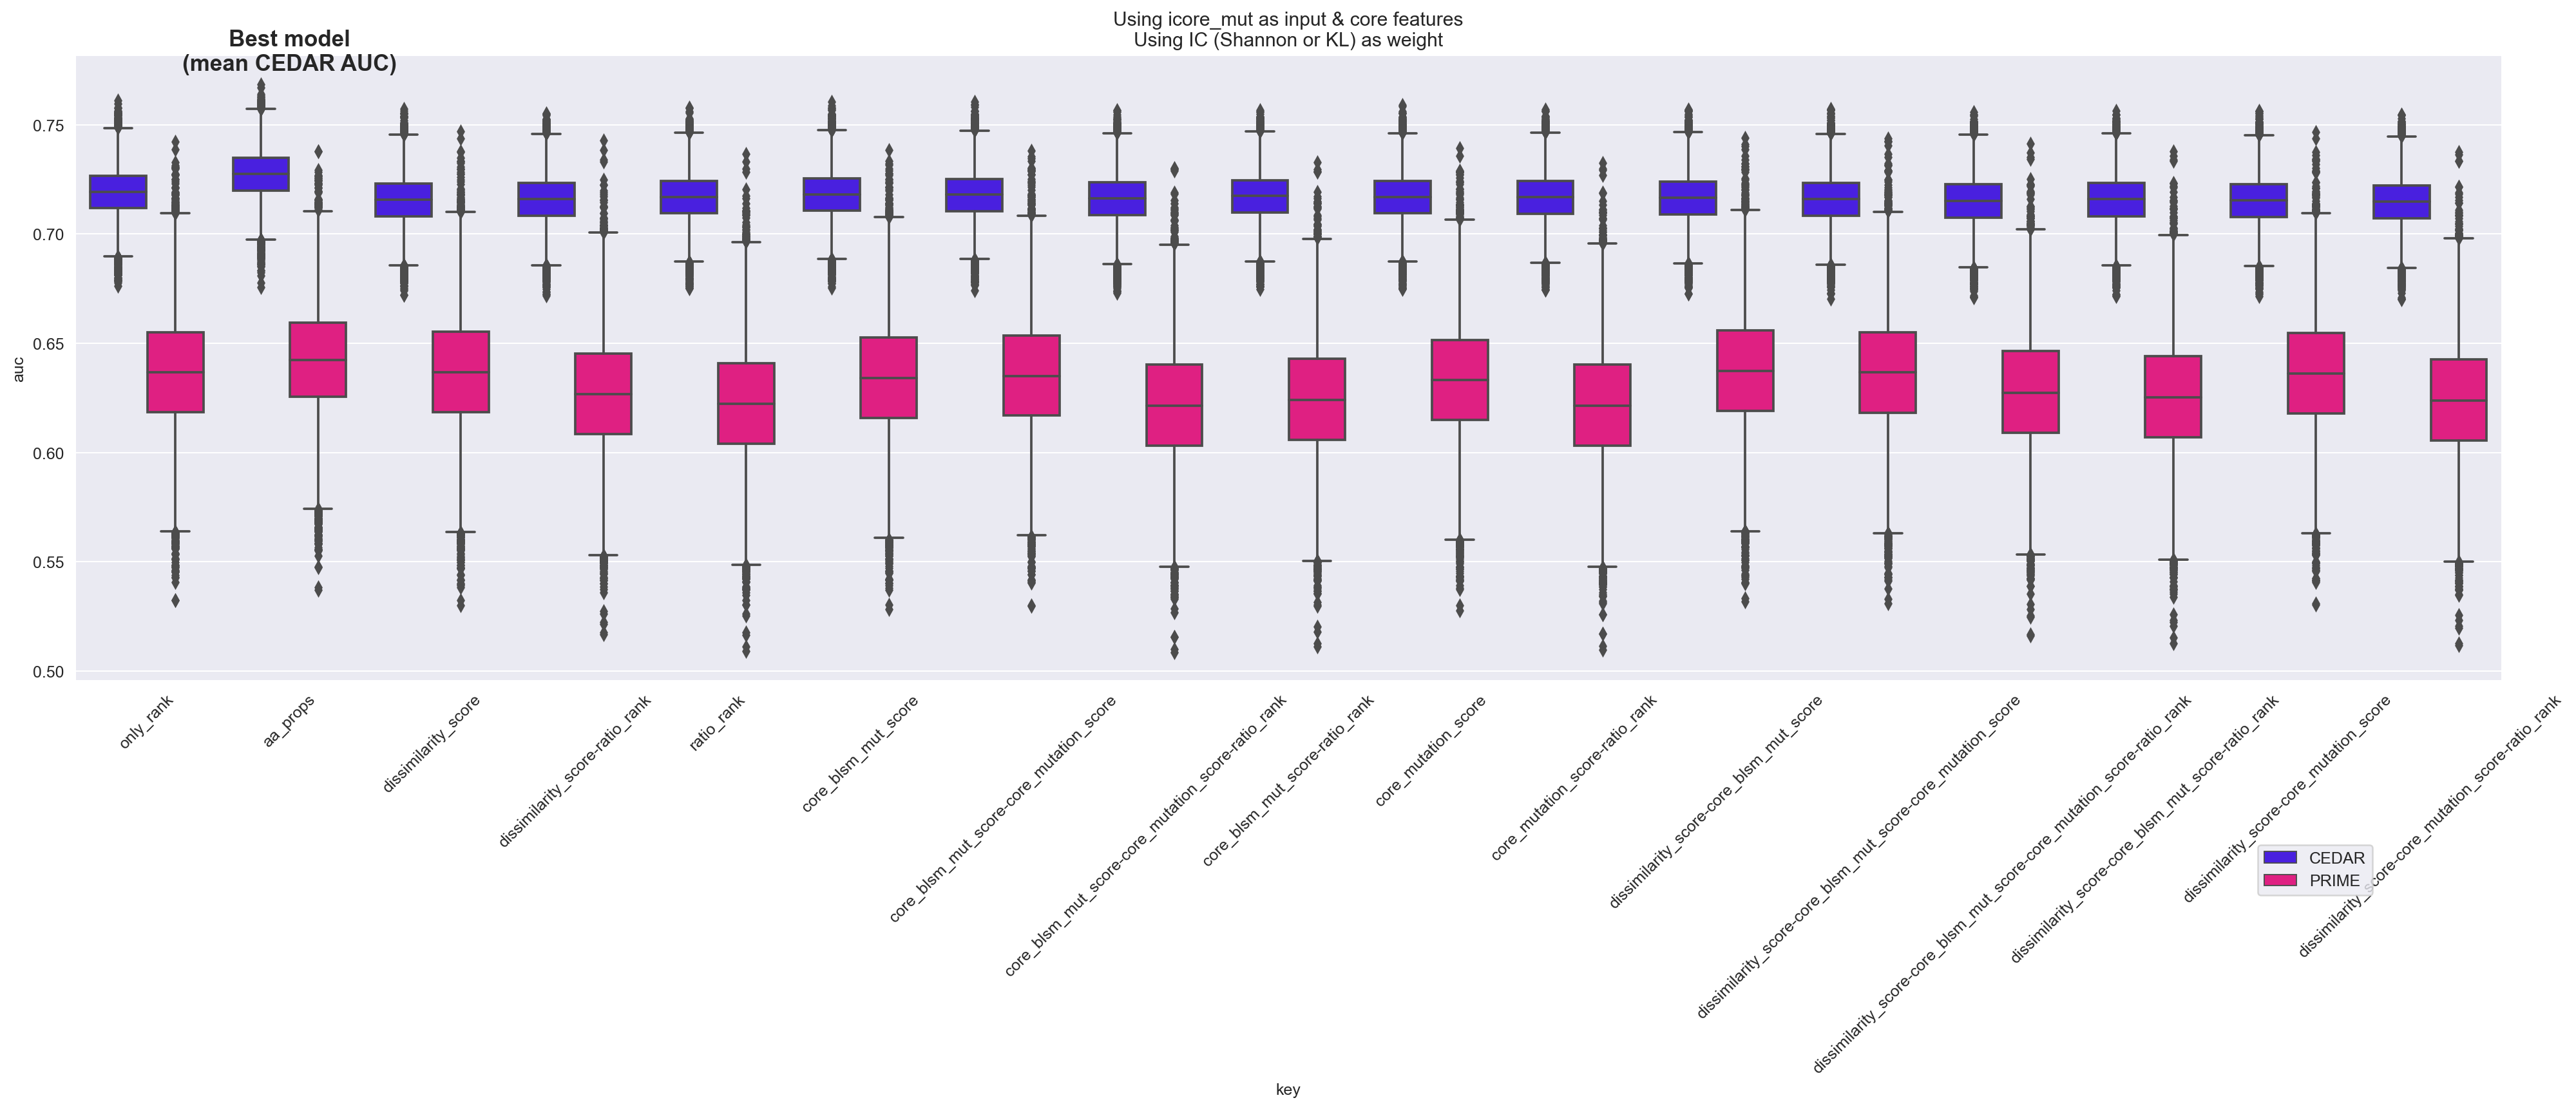

In [518]:
f,a =plt.subplots(1,1, figsize=(27, 7))
sns.boxplot(data=tmp_core, x = 'key', hue = 'evalset', y = 'auc', order=core_keys)
a.set_xticklabels(a.get_xticklabels(), rotation=45)
plt.setp(a.collections, alpha=0.75)
a.set_title('Using icore_mut as input & core features\nUsing IC (Shannon or KL) as weight')

max_name = tmp_core.query('evalset=="CEDAR"').groupby('key').agg(mean_AUC=('auc','mean')).sort_values('mean_AUC', ascending=False).iloc[0].name
max_idx = core_keys.index(max_name)
a.text(max_idx, 0.775, "Best model\n(mean CEDAR AUC)", fontdict={'fontweight':'semibold', 'fontsize':14, 'horizontalalignment':'center'})

a.legend(bbox_to_anchor=(0.95, -0.25))

### Repeat for stuff that works for PRIME

In [482]:
prime_tmp_core = df_results.query('(weight=="(1–IC) Mask") and encoding=="onehot" and rank_col=="EL_rank_mut" and pep_col=="icore_mut" and key in @core_keys')
prime_tmp_non = df_results.query('(weight=="(1–IC) Mask") and encoding=="onehot" and rank_col=="EL_rank_mut" and pep_col=="Peptide" and key in @non_core_keys')

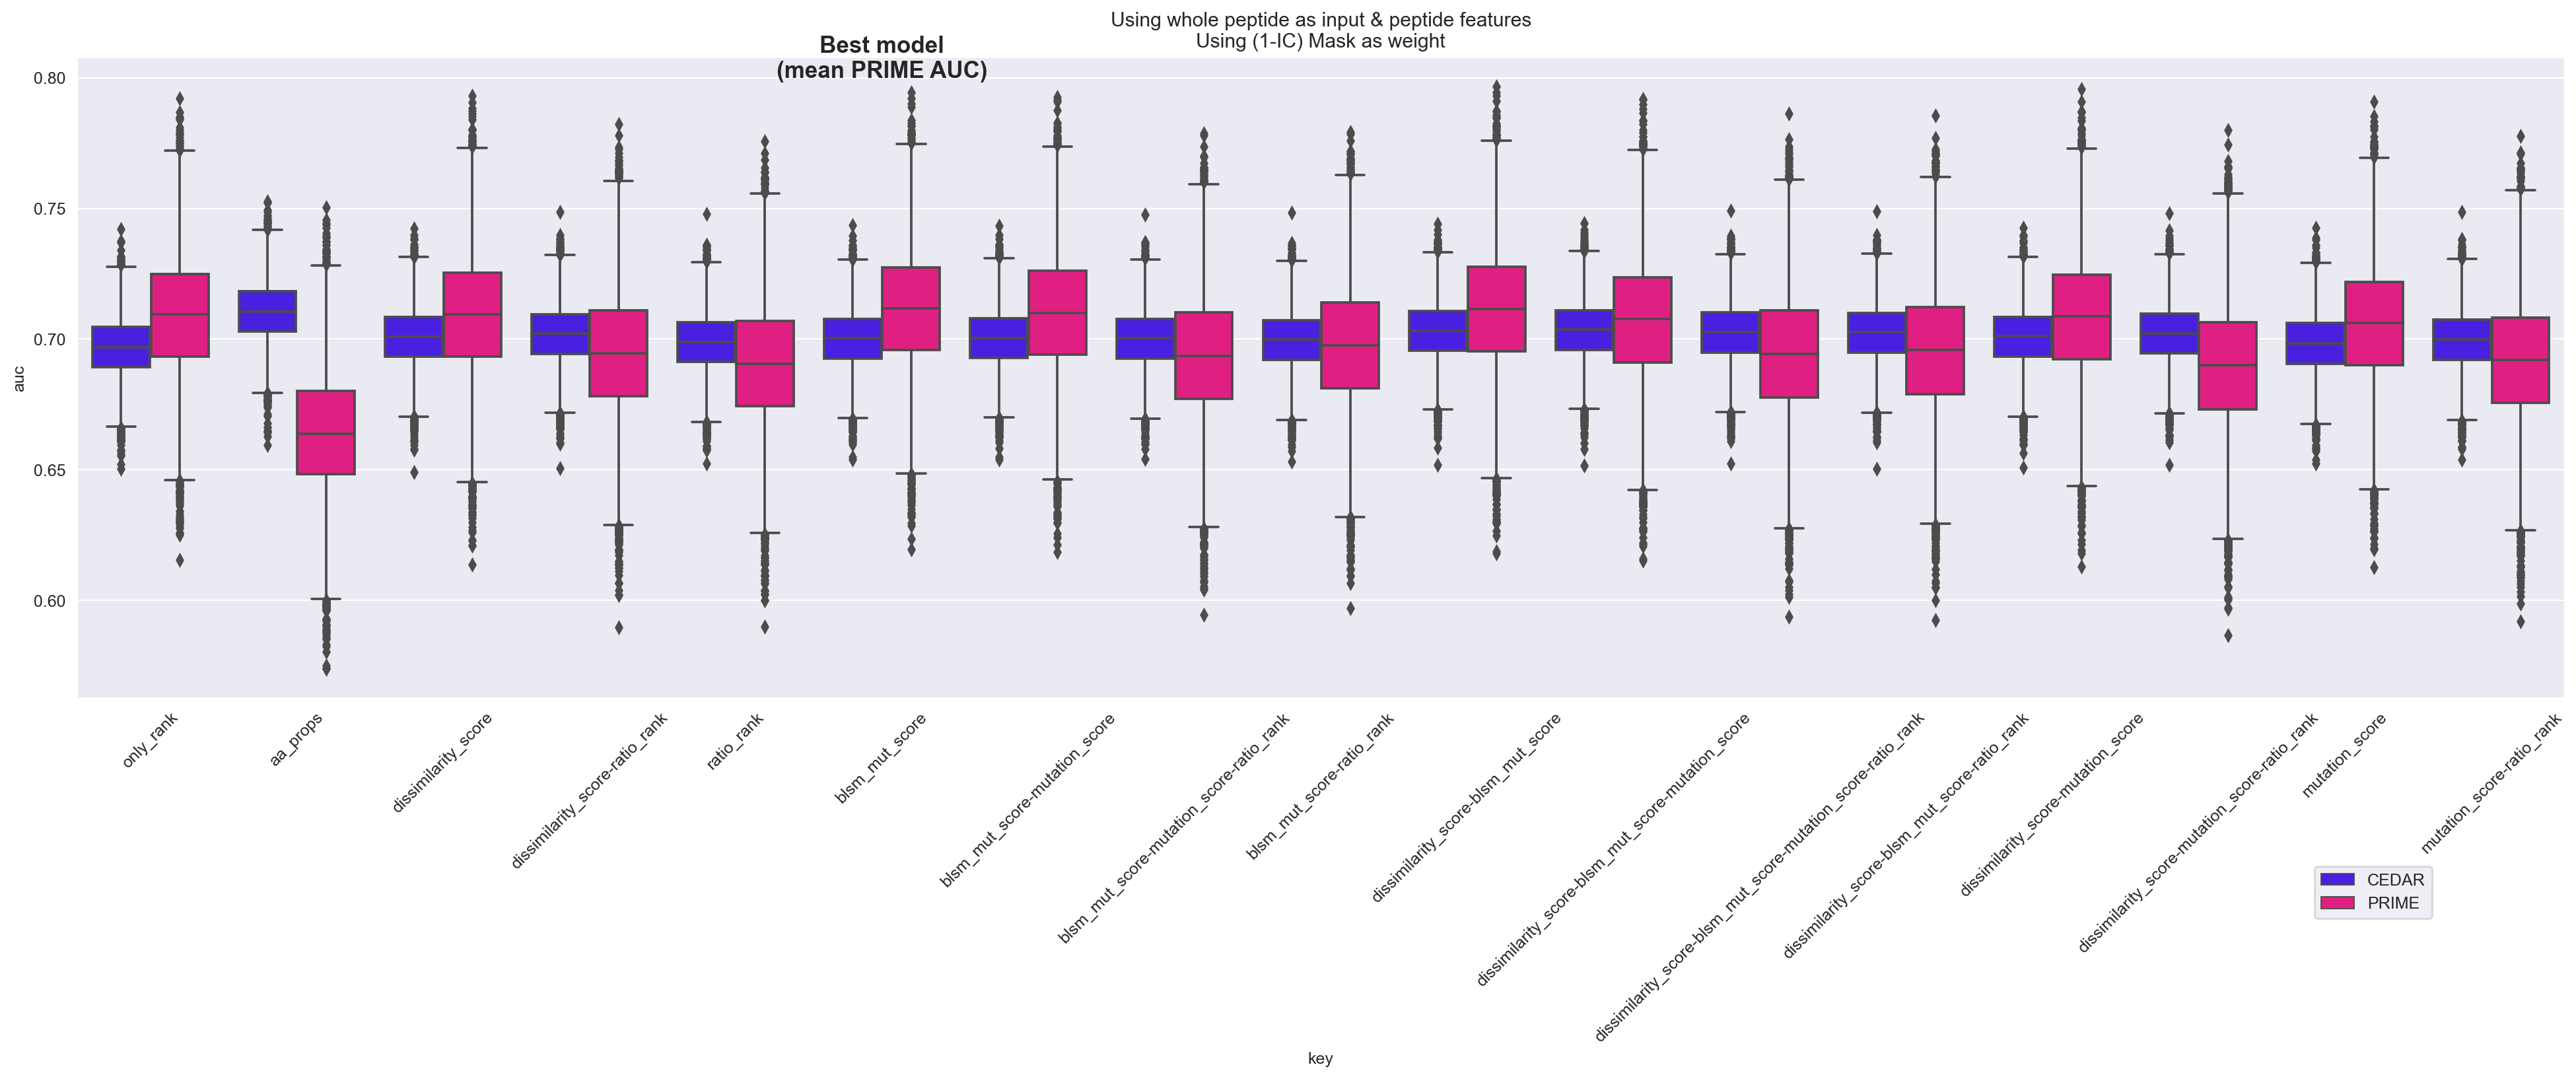

In [517]:
sns.set_palette(HSV)
f,a =plt.subplots(1,1, figsize=(27, 7))
sns.boxplot(data=prime_tmp_non, x = 'key', hue = 'evalset', y = 'auc', order=non_core_keys)
a.set_xticklabels(a.get_xticklabels(), rotation=45)
plt.setp(a.collections, alpha=0.75)
a.set_title('Using whole peptide as input & peptide features\nUsing (1-IC) Mask as weight')

max_name = prime_tmp_non.query('evalset=="PRIME"').groupby('key').agg(mean_AUC=('auc','mean')).sort_values('mean_AUC', ascending=False).iloc[0].name
max_idx = non_core_keys.index(max_name)
a.text(max_idx, 0.8, "Best model\n(mean PRIME AUC)", fontdict={'fontweight':'semibold', 'fontsize':14, 'horizontalalignment':'center'})

a.legend(bbox_to_anchor=(0.95, -0.25))

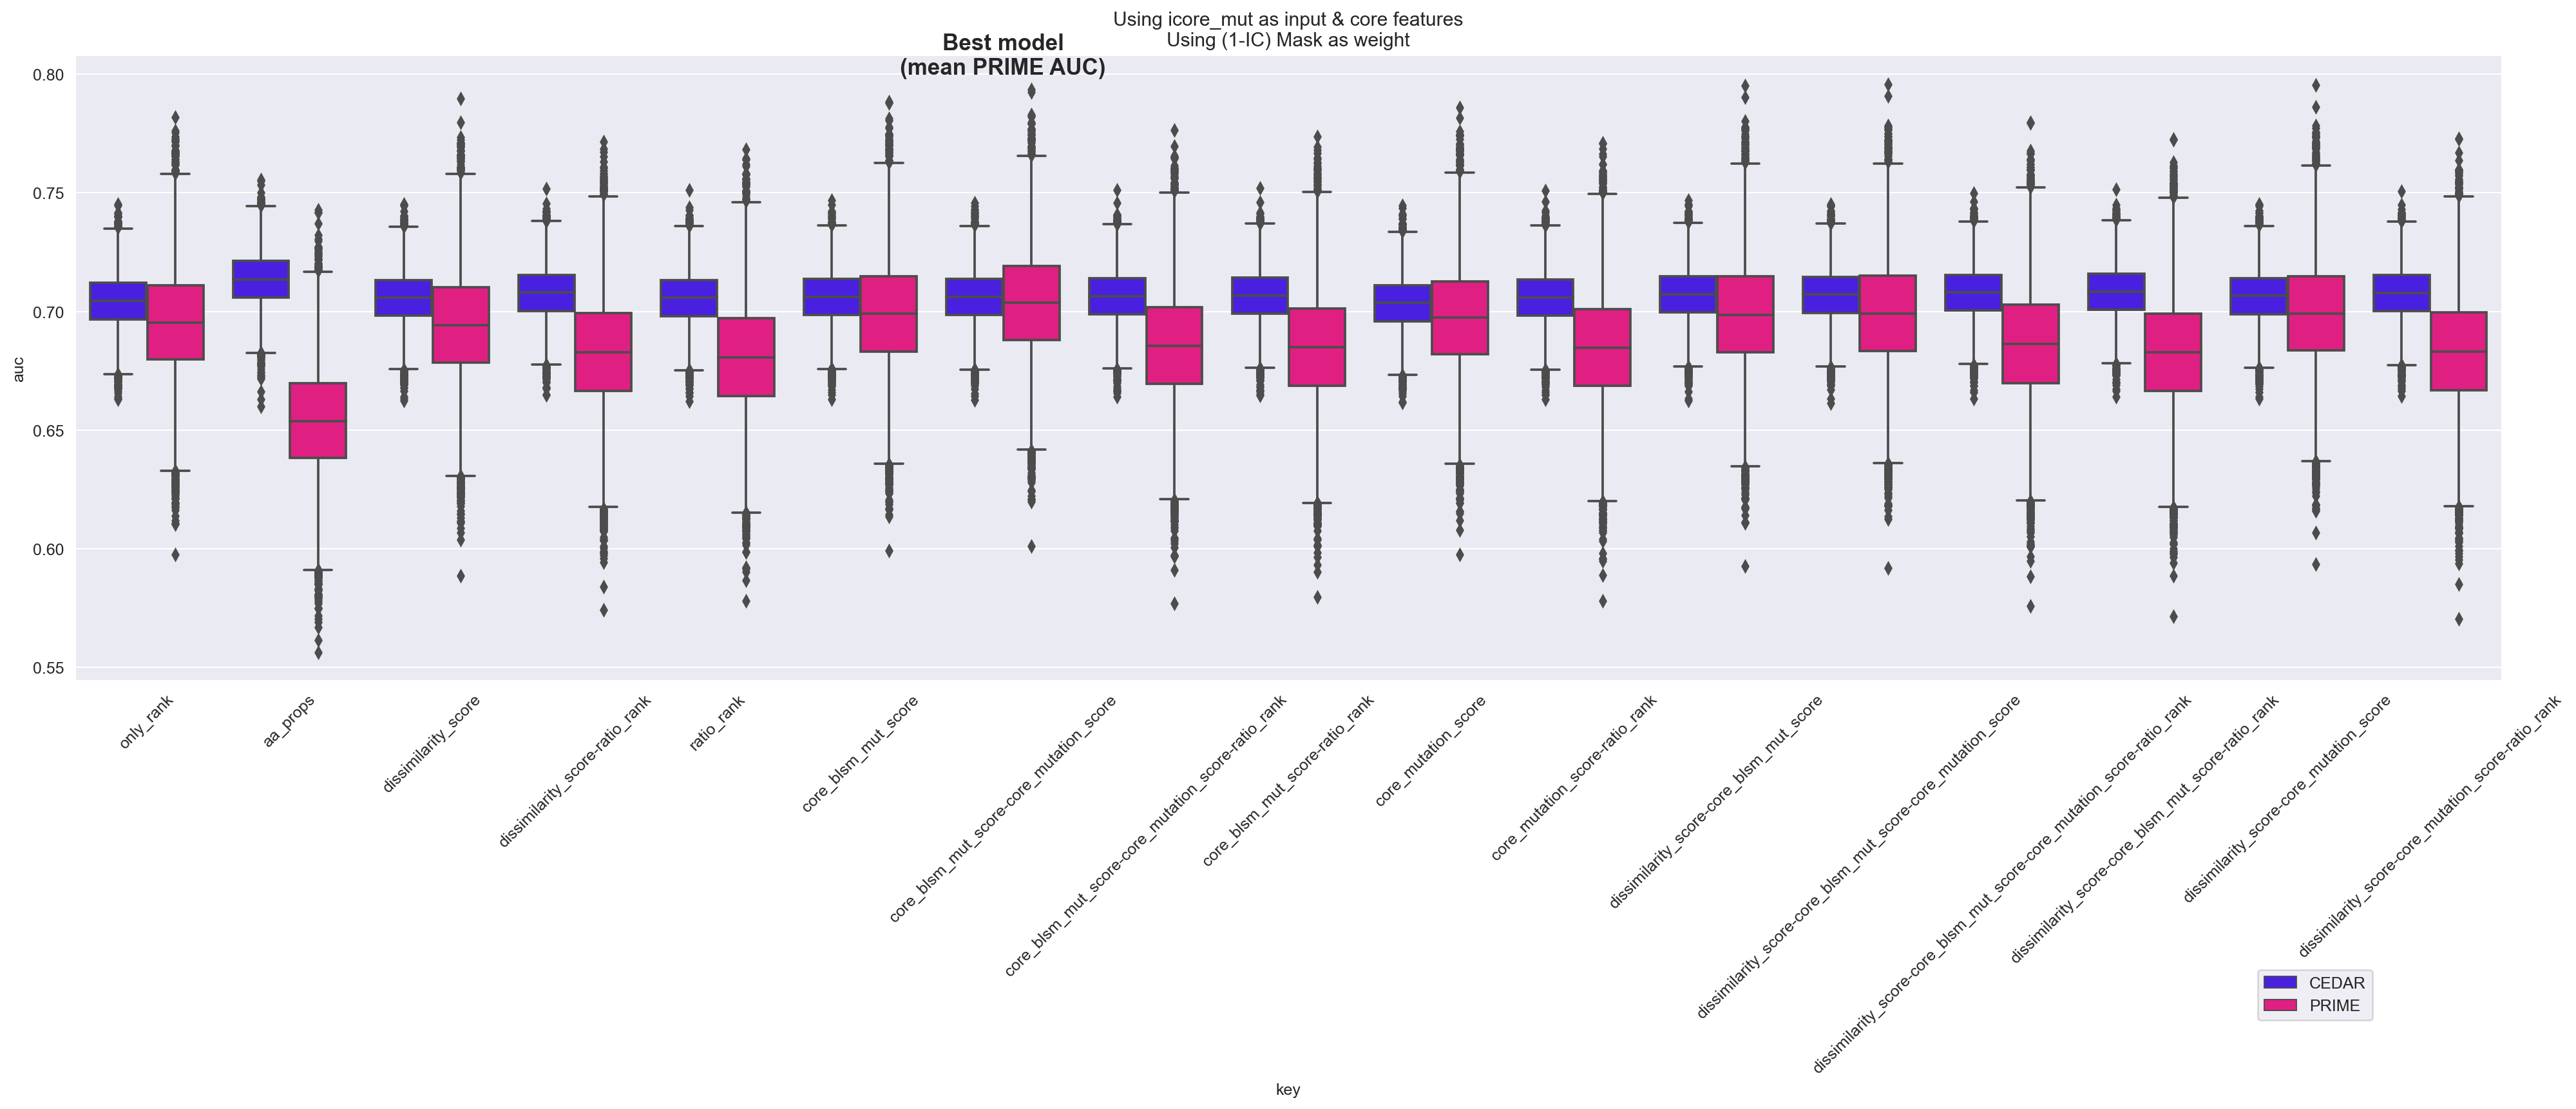

In [522]:
f,a =plt.subplots(1,1, figsize=(27, 7))
sns.boxplot(data=prime_tmp_core, x = 'key', hue = 'evalset', y = 'auc', order=core_keys)
a.set_xticklabels(a.get_xticklabels(), rotation=45)
plt.setp(a.collections, alpha=0.75)
a.set_title('Using icore_mut as input & core features\nUsing (1-IC) Mask as weight')

max_name = prime_tmp_core.query('evalset=="PRIME"').groupby('key').agg(mean_AUC=('auc','mean')).sort_values('mean_AUC', ascending=False).iloc[0].name
max_idx = core_keys.index(max_name)
a.text(max_idx, 0.8, "Best model\n(mean PRIME AUC)", fontdict={'fontweight':'semibold', 'fontsize':14, 'horizontalalignment':'center'})

a.legend(bbox_to_anchor=(0.95, -0.45))

Text(0.5, 1.0, 'Comparison of input format (Peptide vs ICORE) on CEDAR\nFor features without mutation scoring\nUsing IC (Shannon or KL) as weight')

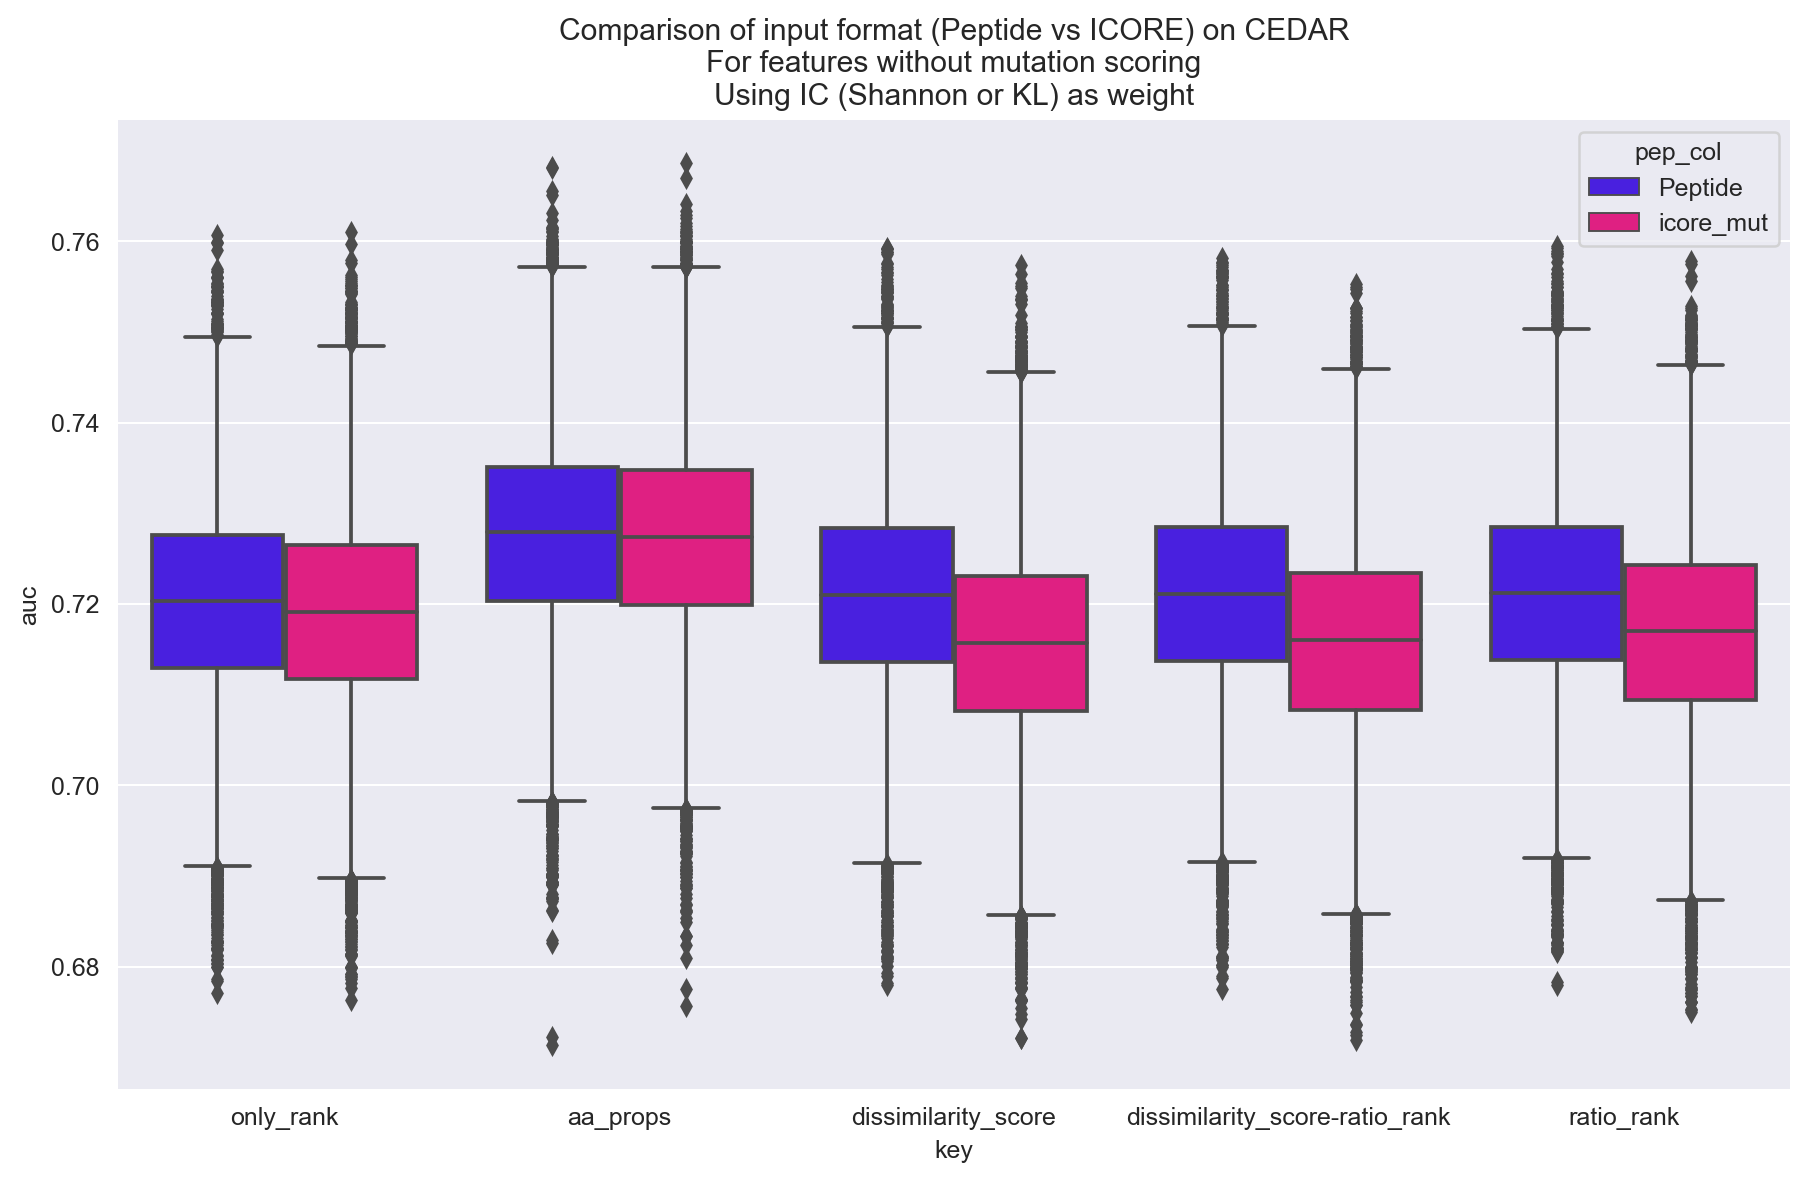

In [696]:
tmp_ = df_results.query('evalset=="CEDAR" and (weight=="IC KL" or weight=="IC Shannon") and encoding=="onehot" and rank_col=="EL_rank_mut" and key in @base_keys')
f,a = plt.subplots(1,1, figsize=(12,7))
sns.boxplot(data=tmp_, x='key', y='auc', hue='pep_col')
plt.setp(a.collections, alpha=0.75)
a.set_title('Comparison of input format (Peptide vs ICORE) on CEDAR\nFor features without mutation scoring\nUsing IC (Shannon or KL) as weight')


Text(0.5, 1.0, 'Comparison of input format (Peptide vs ICORE) on CEDAR\nFor features without mutation scoring\nUsing Mask as weight')

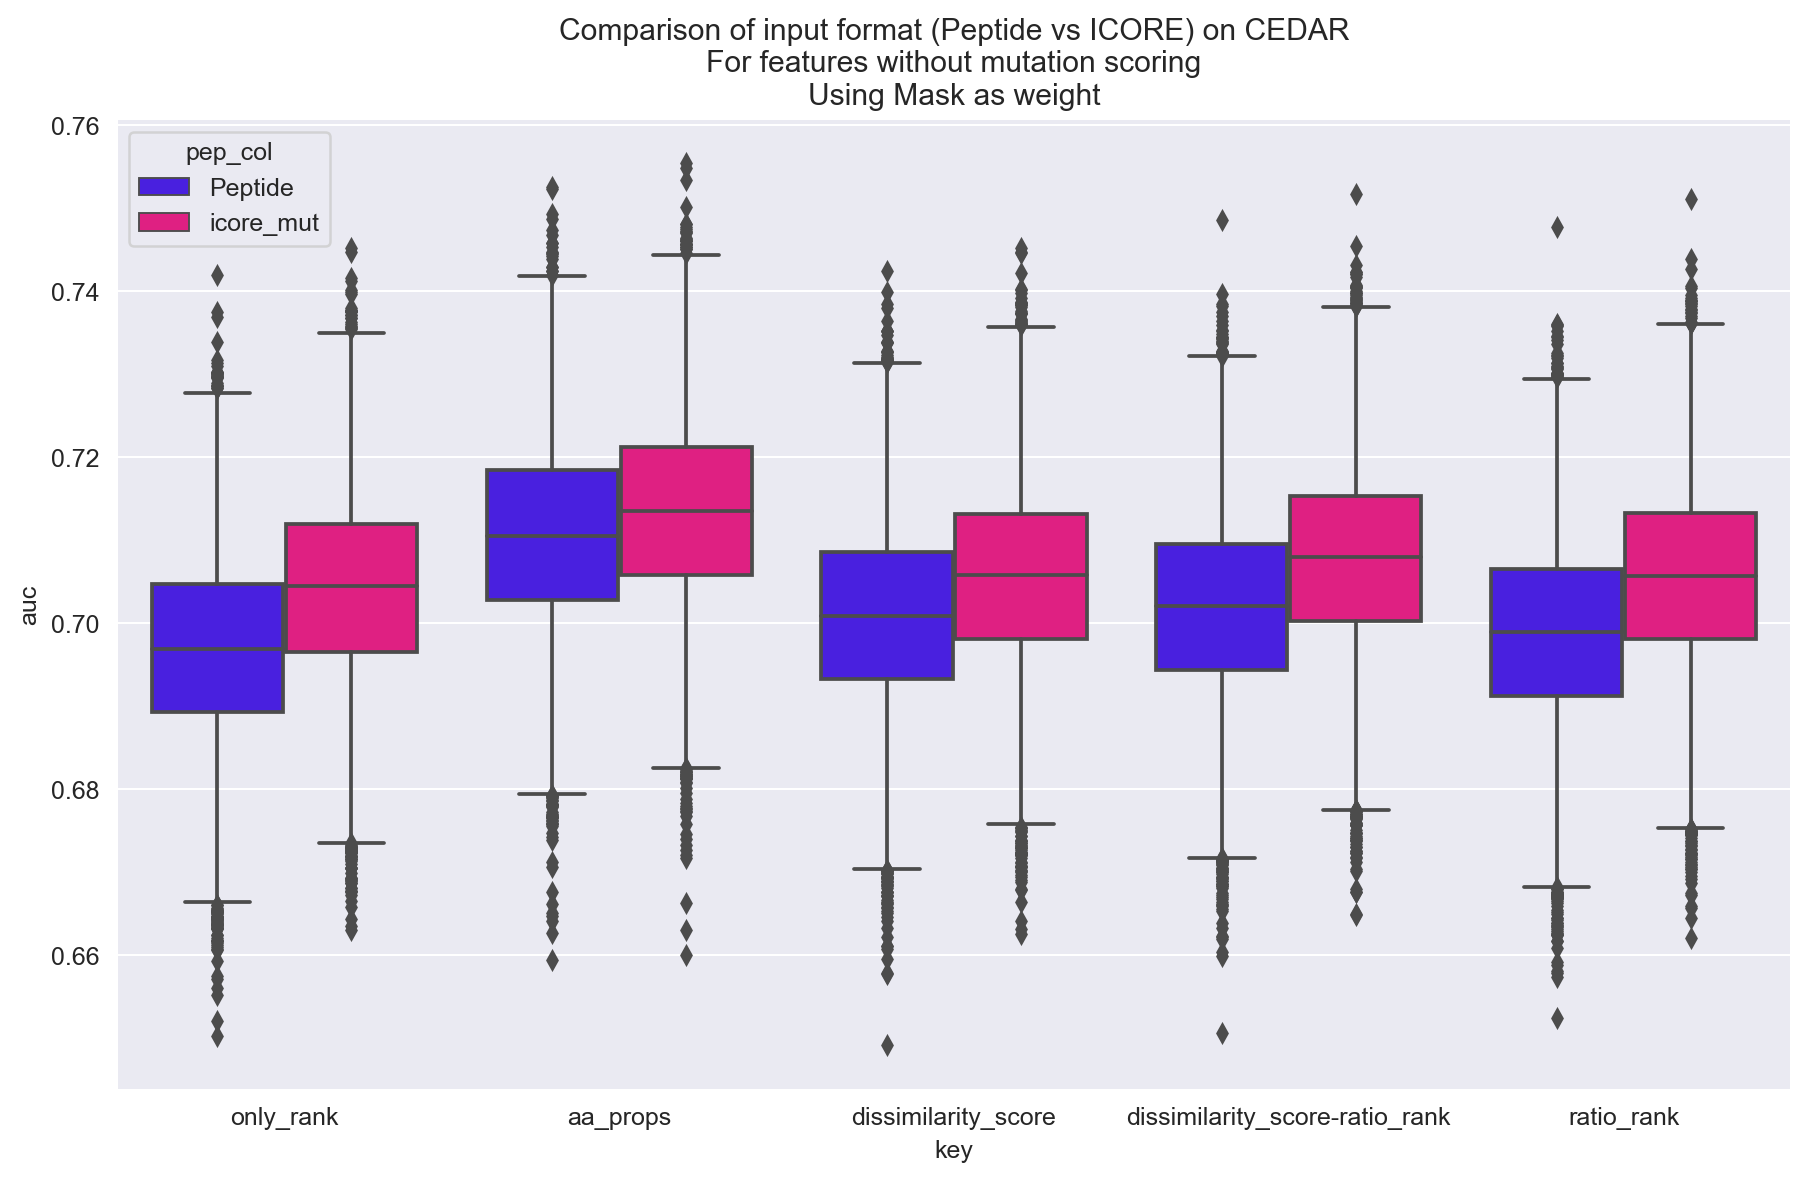

In [697]:
tmp_ = df_results.query('evalset=="CEDAR" and (weight=="(1–IC) Mask") and encoding=="onehot" and rank_col=="EL_rank_mut" and key in @base_keys')
f,a = plt.subplots(1,1, figsize=(12,7))
sns.boxplot(data=tmp_, x='key', y='auc', hue='pep_col')
plt.setp(a.collections, alpha=0.75)
a.set_title('Comparison of input format (Peptide vs ICORE) on CEDAR\nFor features without mutation scoring\nUsing Mask as weight')


In [61]:
ibel_related_merged['Peptide'].to_csv('../data/mutant/ibel_neoepi_pep.txt', index=False, header=False)

In [64]:
','.join(sorted(ibel_related_merged.HLA.str.replace('HLA-','').unique()))

'A0101,A0201,A0301,A1101,A2501,A3101,B0702,B1801,B5101,B5701,C0501,C0602,C0701,C0702,C1502'

In [65]:
ibel_prime_scores = pd.read_csv('../data/mutant/ibel_neoepi_primescore.txt', sep='\t', comment='#')

In [67]:
ibel_related_merged = ibel_related_merged.merge(ibel_prime_scores.rename('Score_bestAllele':'PRIME_score')['Score_bestAllele'], left_index=True, right_index=True)

In [235]:
ibel_related_merged[['Peptide', 'agg_label']].to_csv('../../ibel_pep_nnalign.pep', index=False, header=False, sep='\t')